In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm.notebook import tqdm

In [2]:
sns.set("notebook", style="white")

### Height and gravity

In [3]:
delta_t = 2
x_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
x_plot = np.linspace(-2, 2, 1000)

In [4]:
def height(x):
    
    if x <= 0:
        y = x**2 + x + 0.25
    else:
        y = x*(1+5*x**2)**(-1/2) + (1/32)*(x**4) + 0.25
    
    return y

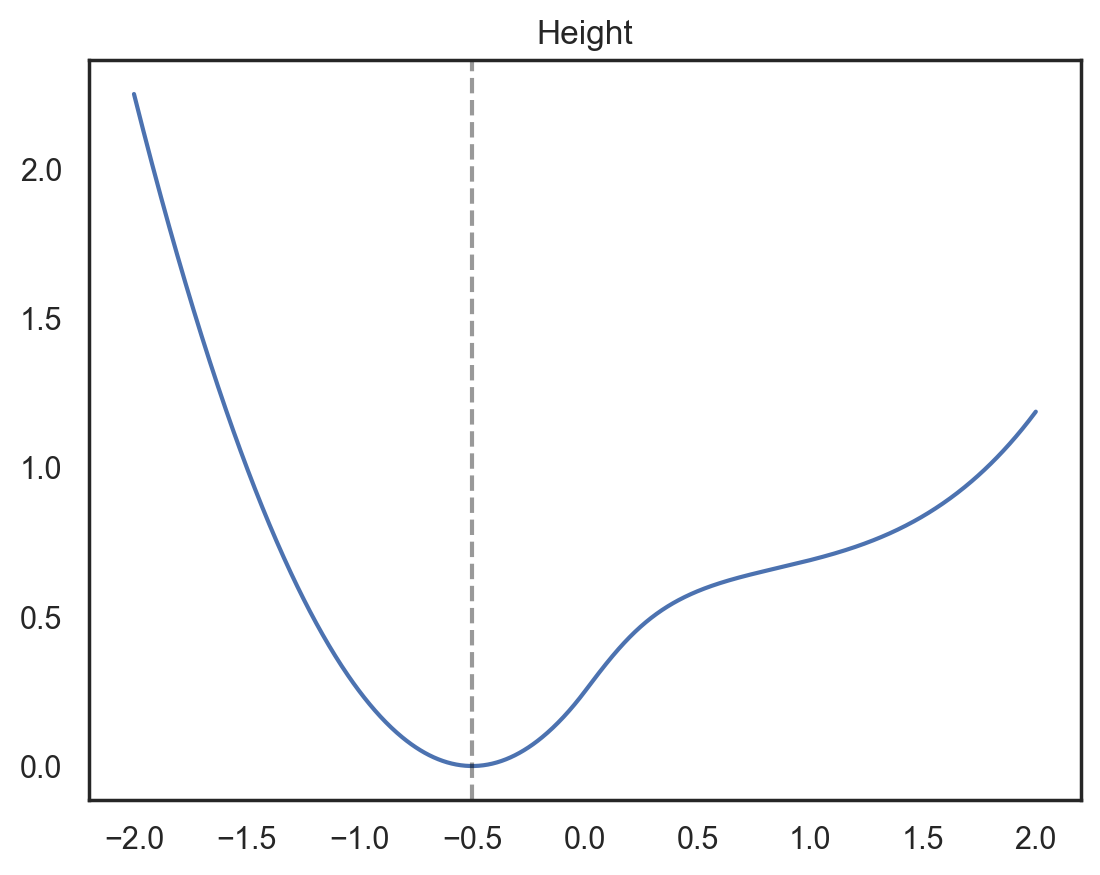

In [5]:
fig, ax = plt.subplots()
ax.plot(x_plot, [height(x) for x in x_plot])
ax.set_title("Height")
ax.axvline(-0.5, linestyle="--", color="black", alpha=0.4);

In [6]:
def phi(x):
    phi = np.zeros_like(x)
    is_leq0 = x<=0
    phi_1 = 2*x+1
    a = (1 + 5*x**2)
    phi_2 = a**(-0.5)
    phi_3 = - 5*x**2*a**(-1.5)
    phi_4 = (x/2)**4 # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]  
    return - phi
#     if x <= 0:
#         return -2*x - 1
#     else:
#         return # (1+5*x**2)**(-1/2)- 5*x**2*(1+5*x**2)**(-3/2) + 0.5*x**4 
#         # -(1+5*x**2)**(-3/2) - (1/8)*x**3

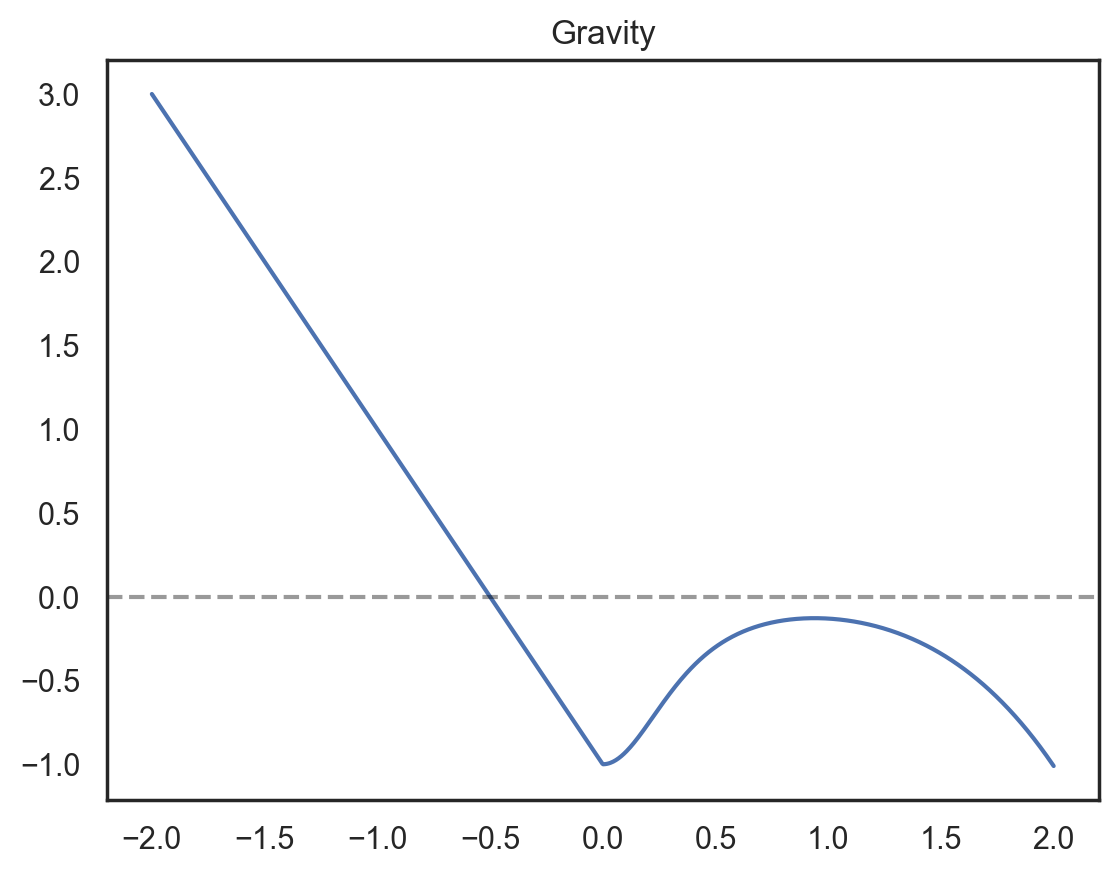

In [7]:
fig, ax = plt.subplots()
ax.plot(x_plot, phi(x_plot))
ax.axhline(0, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gravity");

In [8]:
def update_position_and_velocity(position, velocity, action):
    force_action = np.tanh(action)
    force_friction = -(1/8) * velocity
    force_gravity = phi(position)
    force = force_gravity + force_friction + force_action
    velocity += force
    position += velocity
    return position, velocity

## Gym

In [9]:
import gym

In [10]:
env = gym.make("MountainCar-v0")

In [11]:
env.reset()

array([-0.44917187,  0.        ], dtype=float32)

In [12]:
env.step(2)

(array([-4.4872546e-01,  4.4642482e-04], dtype=float32), -1.0, False, {})

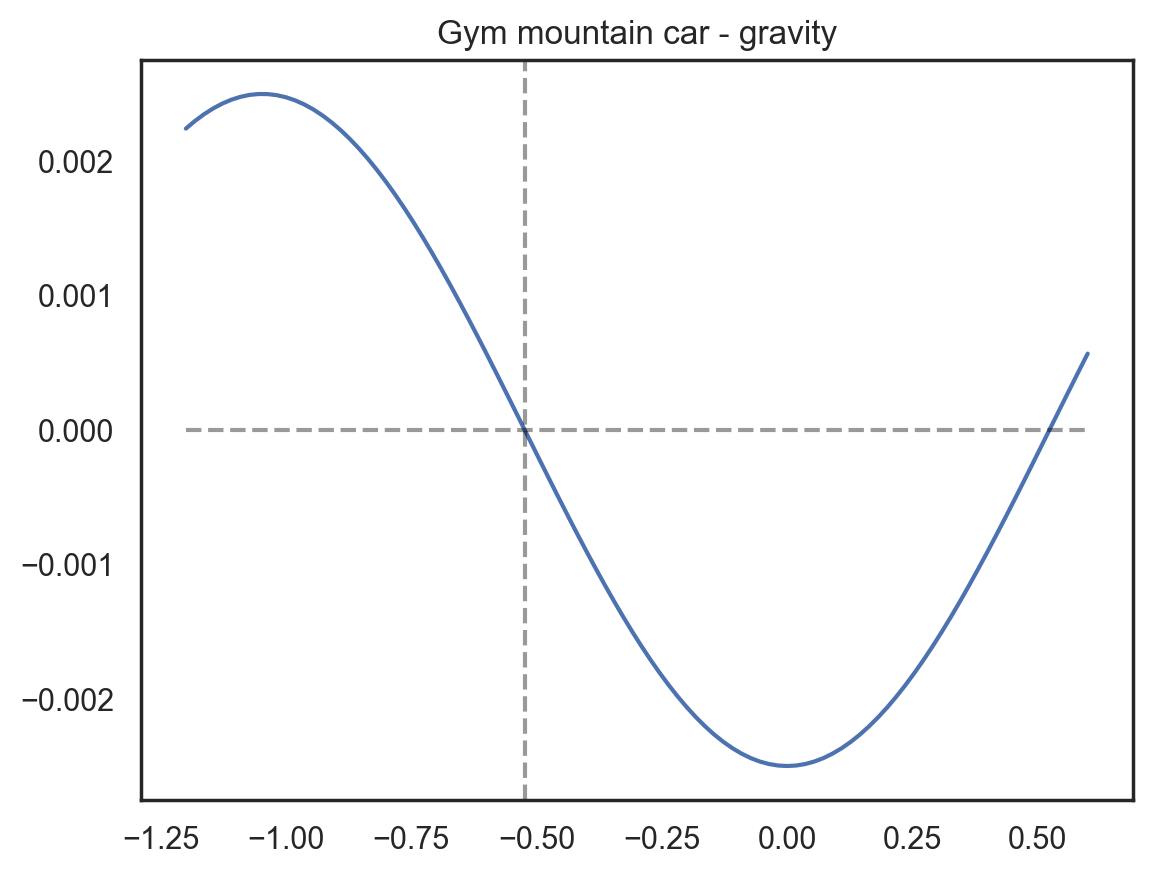

In [13]:
x_gym = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots()
ax.plot(x_gym, -0.0025 * np.cos(3*x_gym))
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.hlines(0., xmin=x_gym[0], xmax=x_gym[-1], linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - gravity");

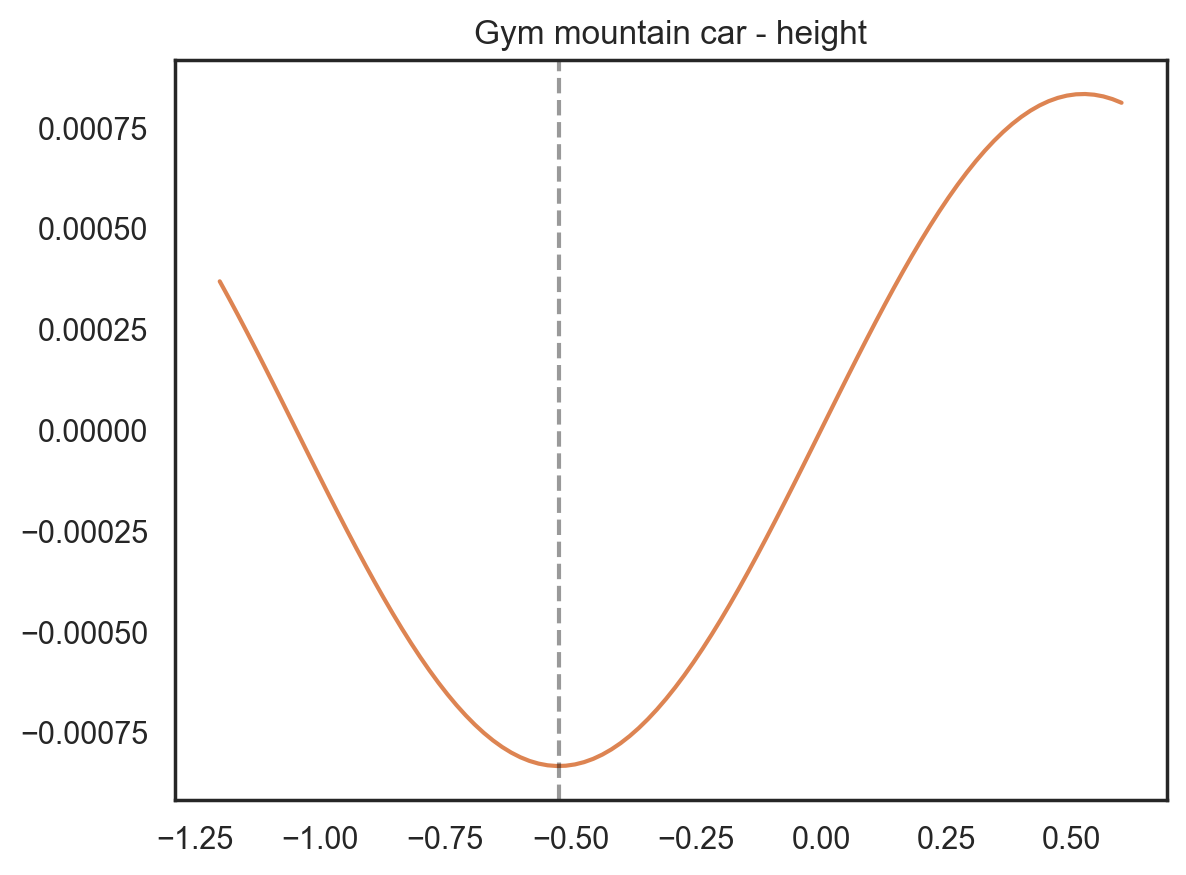

In [14]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200, color="C1")
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - height");

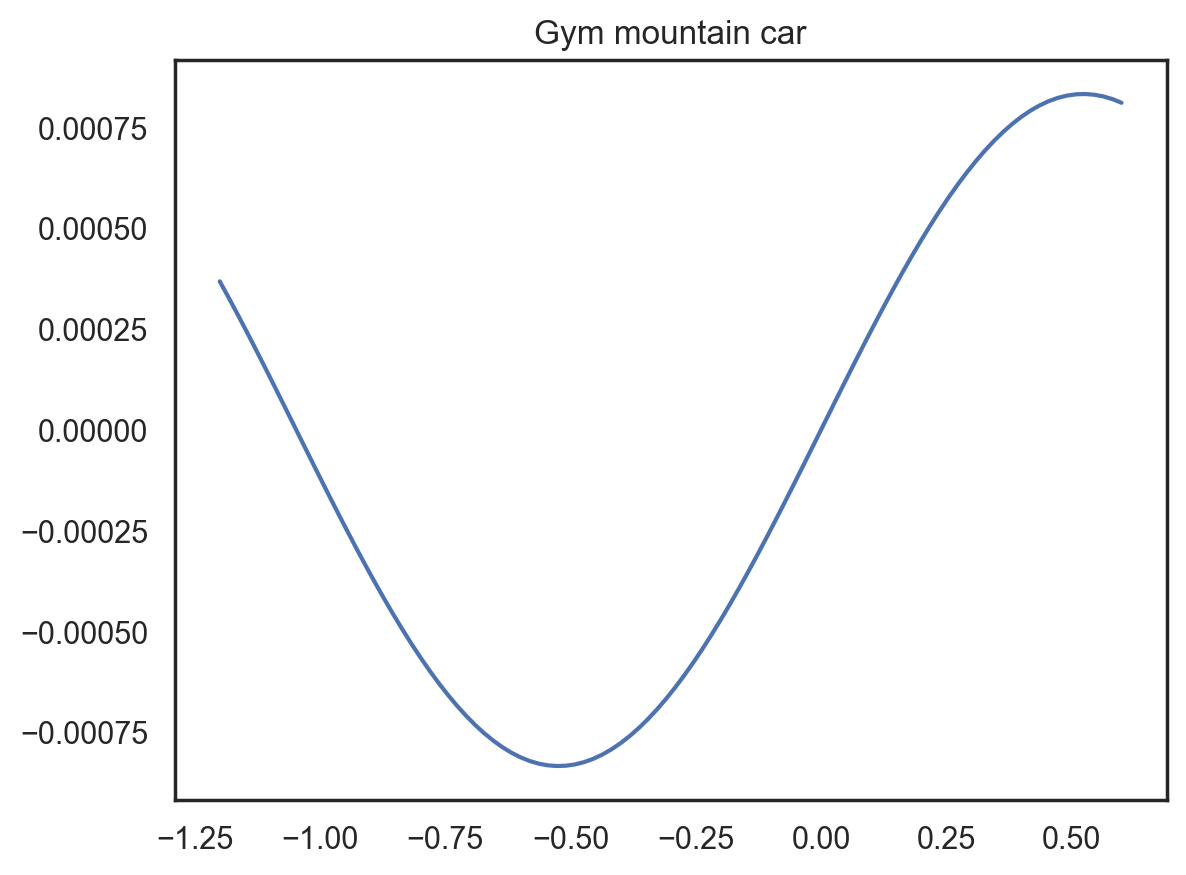

In [15]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200)
ax.set_title("Gym mountain car");

In [16]:
def dynamics_gym(position, velocity, action, gravity=0.0025, force=0.001):
    assert action in [-1, 0, 1], "Action needs to be either -1, 0, or 1"
    velocity += action*force - np.cos(3 * position) * gravity
    position += velocity
    return position, velocity

In [17]:
position, velocity = -np.pi/6, 0
actions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
for i, action in enumerate(actions):
    position, velocity = dynamics_gym(position, velocity, action)
    velocity = np.clip(velocity, -0.07, 0.07)
    position = np.clip(position, -1.2, 0.6)
    print(i, action, position, velocity)

0 1 -0.5225987755982988 0.0009999999999999998
1 1 -0.5206062755870489 0.0019925000112499943
2 1 -0.5176362190244069 0.0029700565626419734
3 1 -0.5137108792513178 0.003925339773089185
4 1 -0.5088596878254337 0.004851191425884095
5 1 -0.5031190035396563 0.00574068428577737
6 1 -0.4965318209290182 0.006587182610638135
7 1 -0.48914741746676027 0.007384403462257964
8 1 -0.4810209394215762 0.008126478045184092
9 1 -0.47221292748890664 0.00880801193266958


## Backward motion

#### Old motion Implementation

In [18]:
# def forward_motion(motion, action, delta_t, scale_gravity, scale_friction):
    
#     def _equations_of_motion(t, x, *args):
#         action,  = args
#         position, velocity = x

#         force_action = np.tanh(action)

#         force_friction = -scale_friction * velocity

#         if position <= 0:
#             force_gravity = -2*position - 1
#         else:
#             # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
#             force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

#         force_gravity *= scale_gravity # Scale it

#         force = force_gravity + force_friction + force_action
#         change_in_velocity = force
#         change_in_position = velocity
        
#         if (velocity >= 3 and change_in_velocity > 0) \
#                 or (velocity <= -3 and change_in_velocity < 0):
#             change_in_velocity = 0
        
#         if (position <= -2 and change_in_position < 0) \
#                 or (position >= 2 and change_in_position > 0):
#             change_in_position = 0
#             change_in_velocity = - velocity # zeroing out velocity
            
#         dy = np.array([change_in_position, change_in_velocity])
#         return dy
    
# #     def _bounds(t, y):
# #         position, velocity = y.reshape((2,))
# #         if position <= -2 or position >=2 or velocity <= -3 or velocity >= 3
# #             return True
# #         else:
# #             return False
    
#     sol = scipy.integrate.solve_ivp(
#         fun=_equations_of_motion, 
#         y0=motion,
#         args=(action, ), 
#         t_span=[0, delta_t, ],
#         t_eval=[delta_t, ])
#         # events=_bounds)
    
#     position, velocity =  sol.y.reshape((2,))
#     position = np.clip(position, -2, 2)
#     velocity = np.clip(velocity, -3, 3)
#     return np.array([position, velocity])

#### New implementation

In [19]:
def plot_belief(b, fig=None, ax=None, colorbar=True, colormap="gray"):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    pos = ax.imshow(
        b.reshape(len(position_space), len(velocity_space)), 
        origin="lower", 
        extent=(min(position_space), max(position_space),
                min(velocity_space), max(velocity_space)),
        aspect=(max(position_space)-min(position_space)) 
            /(max(velocity_space)-min(velocity_space)),
        cmap=colormap)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    if colorbar:
        fig.colorbar(pos)

In [20]:
delta_t = 1.
scale_gravity = 0.44
scale_friction = 0.25 # 0.04 # 0.125 # 1/8
scale_action = 0.25
scale_position = 0.5
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

In [21]:
def forward_motion(motion, action, delta_t, 
                   scale_gravity, scale_friction, scale_action, scale_position):
    
    position, velocity = motion

    force_action = scale_action * np.tanh(action)

    force_friction = -scale_friction * velocity

    if position <= 0:
        force_gravity = -2*position - 1
    else:
        a = (1 + 5*position**2)
        phi_2 = a**(-0.5)
        phi_3 = - 5*position**2*a**(-1.5)
        phi_4 = (position/2)**4 # negative of paper
        phi = phi_2 + phi_3 + phi_4
        # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
        # force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3
        force_gravity = -phi
        
    force_gravity *= scale_gravity # Scale it

    force = force_gravity + force_friction + force_action
    change_in_velocity = force
    change_in_position = scale_position*velocity

    if (velocity >= 3 and change_in_velocity > 0) \
            or (velocity <= -3 and change_in_velocity < 0):
        change_in_velocity = 0

    if (position <= -2 and change_in_position < 0) \
            or (position >= 2 and change_in_position > 0):
        change_in_position = 0
        change_in_velocity = - velocity # zeroing out velocity
    
    position += change_in_position
    velocity += change_in_velocity
    
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

In [22]:
coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)   

p_forward = np.zeros((n_action, n_state, n_state))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(n_action):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t,
            scale_gravity=scale_gravity,
            scale_friction=scale_friction,
            scale_action=scale_action,
            scale_position=scale_position)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(n_state)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p_forward[idx_act, idx, :] =  s
        p_forward[idx_act, idx, :] /= p_forward[idx_act, idx, :].sum()

In [25]:
p_backward = np.zeros_like(p_forward)
for idx_act in range(n_action):
    p_backward[idx_act] = p_forward[idx_act]
    for idx in range(n_state):
        bwd_sum = p_backward[idx_act, :, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, :, idx] /= bwd_sum # Normalize

In [26]:
n_steps_variations = [0, 4, 8]

belief_plot = np.zeros((n_action, len(n_steps_variations), n_state))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    belief = np.zeros(n_state)
    dist, idx = tree.query(starting_motion)
    belief[idx] = 1

    step = 0
    for step in range(n_steps_variations[-1]+1):
        if step in n_steps_variations:
            belief_plot[idx_act, n_steps_variations.index(step), :] = belief

#         new_b = np.zeros_like(b)
#         for idx_future in range(state_space_size):
#             for idx_past in range(state_space_size):
#                 new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_past, idx_future]

        belief = np.dot(p_backward[idx_act], belief)
        step += 1

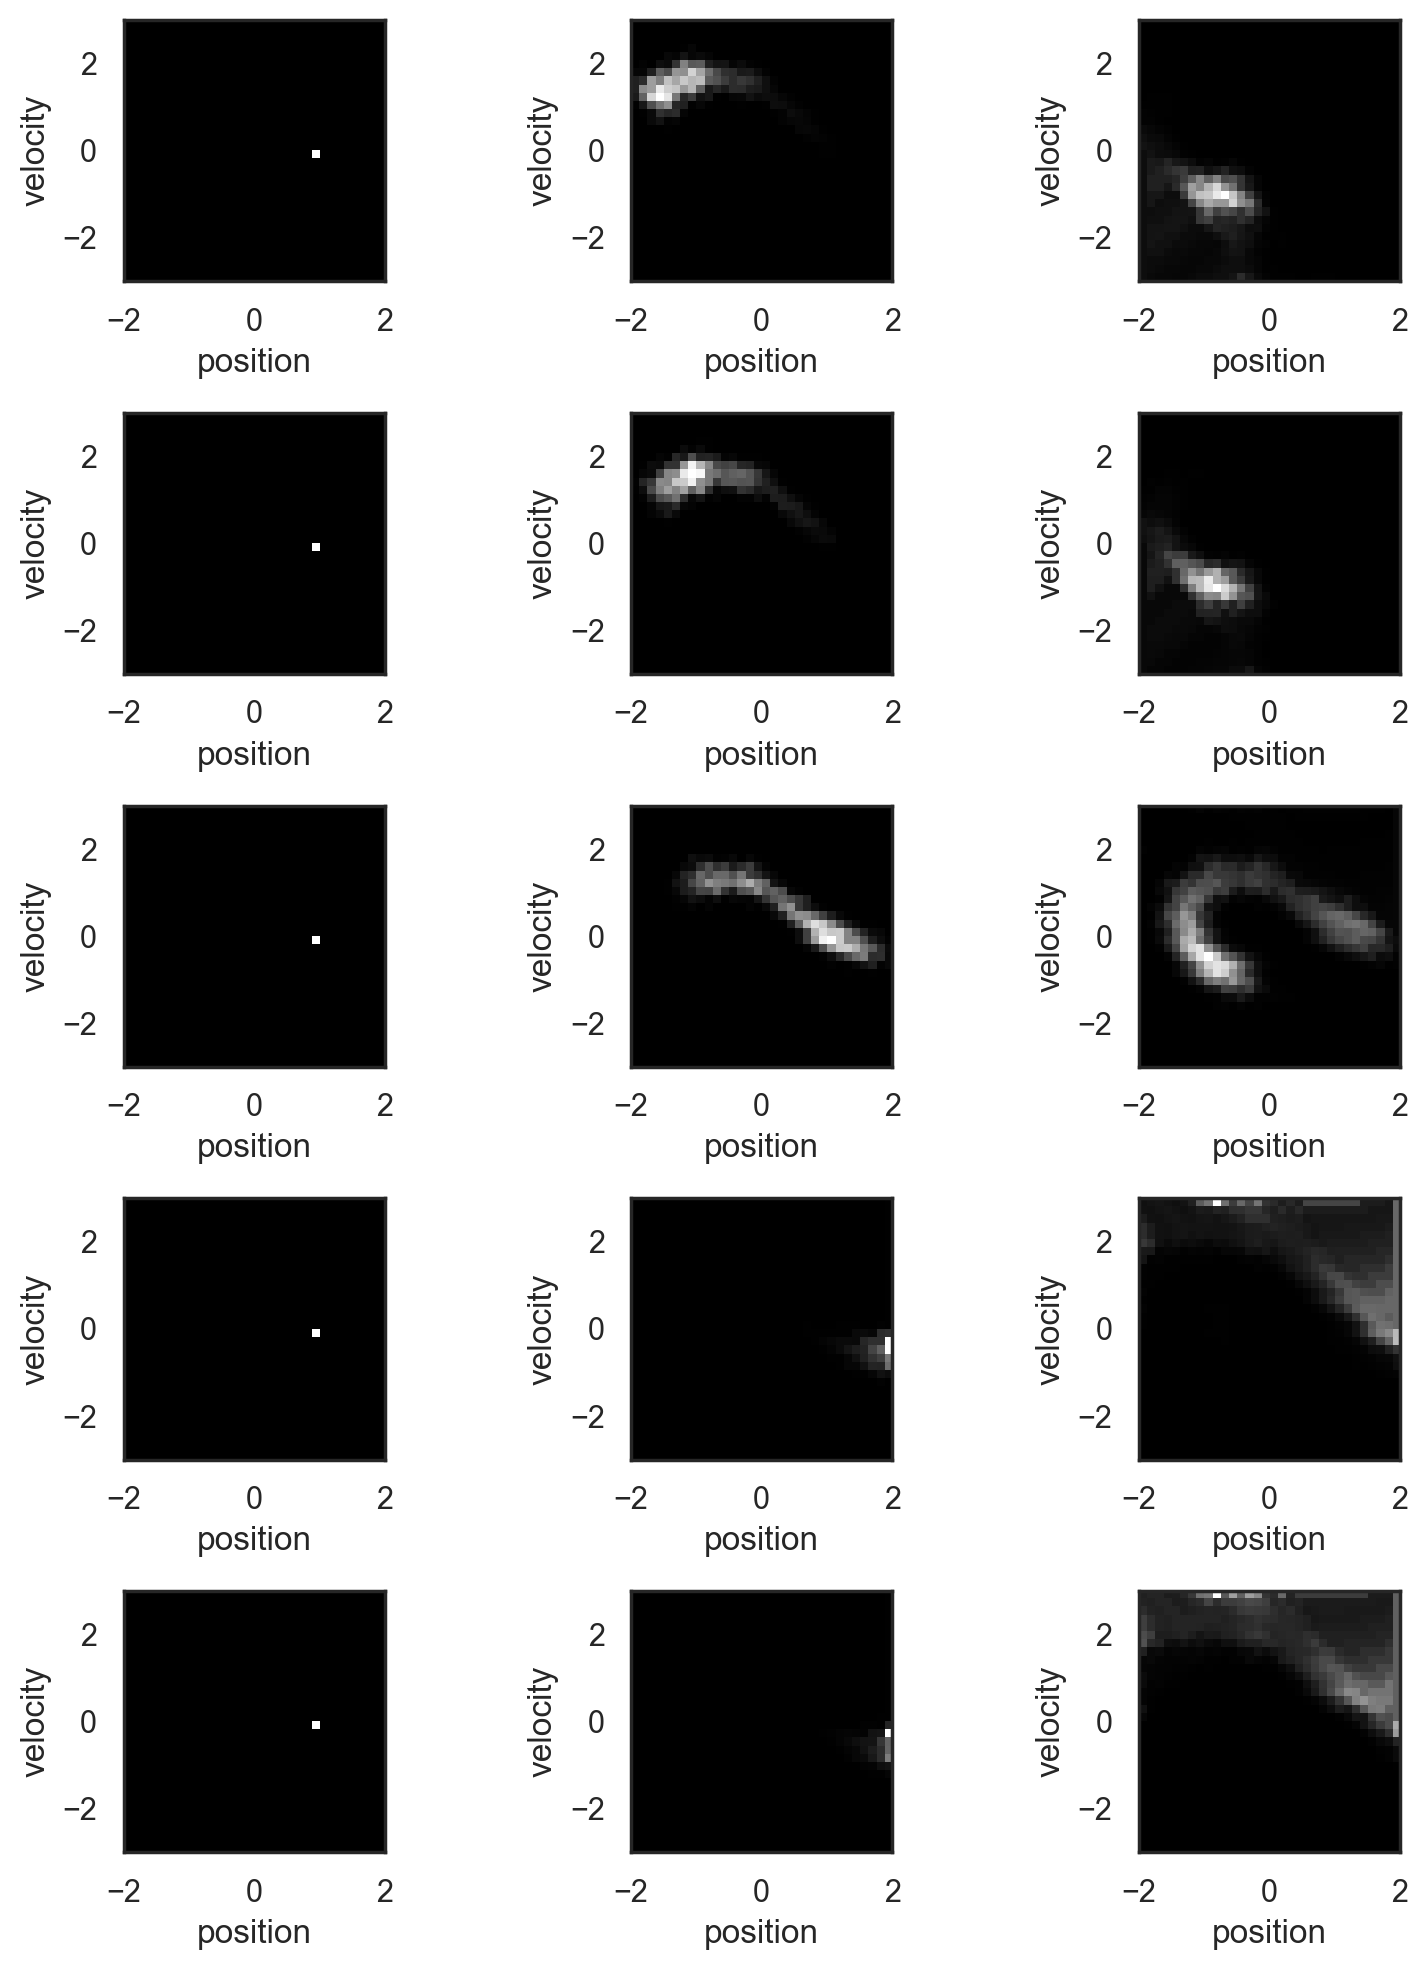

In [27]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(8, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

        try:
            ax = axes[idx_row, idx_col]
        except IndexError:
            ax = axes[idx_col]
        plot_belief(belief_plot[idx_row, idx_col], 
                    ax=ax, fig=fig, colorbar=False)

plt.tight_layout()

### Testing going backward

In [31]:
starting = np.array([0.0, 0.0])
_, state_idx = tree.query(starting)
state_idx

495

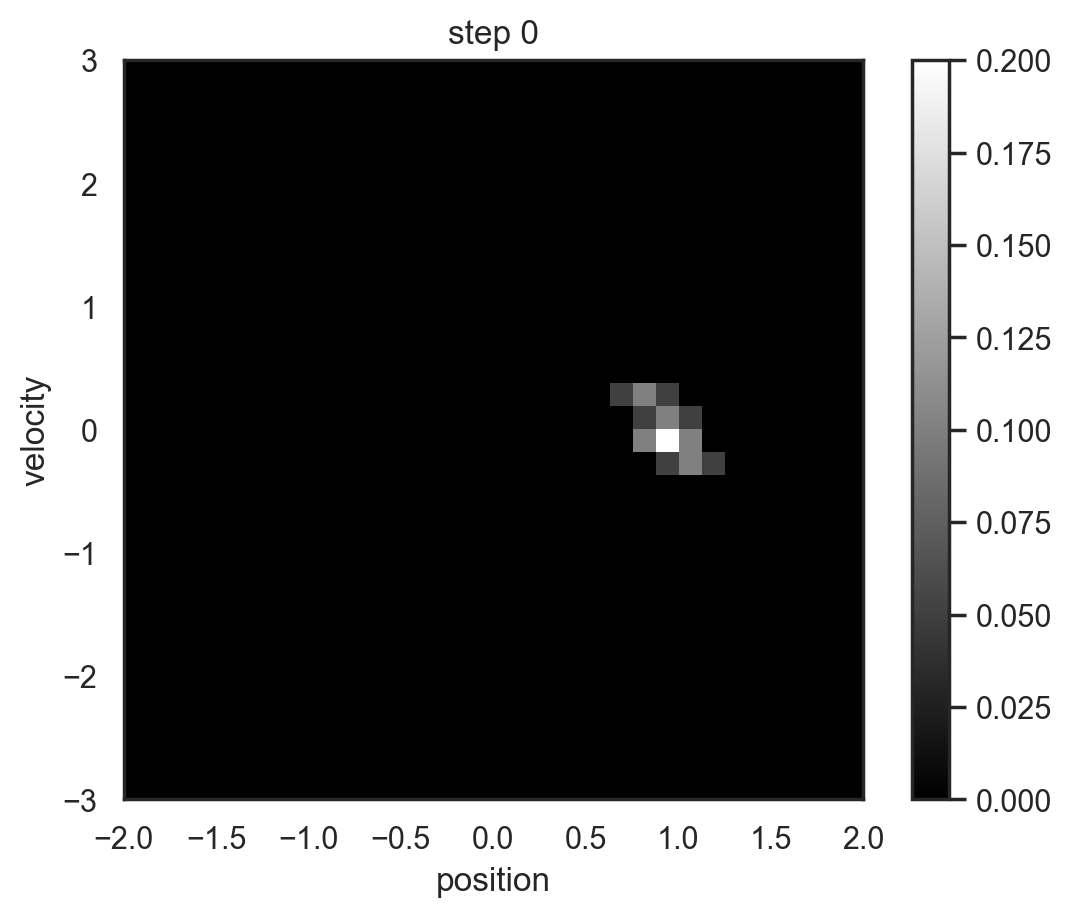

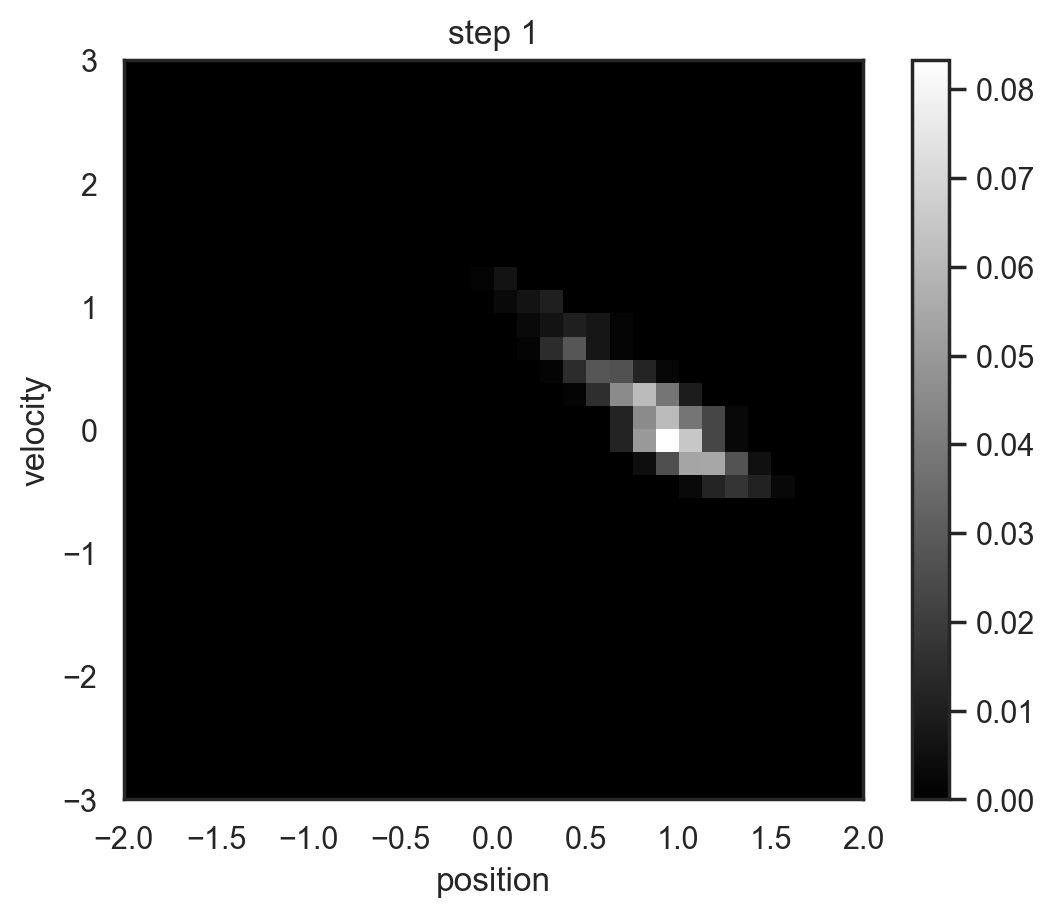

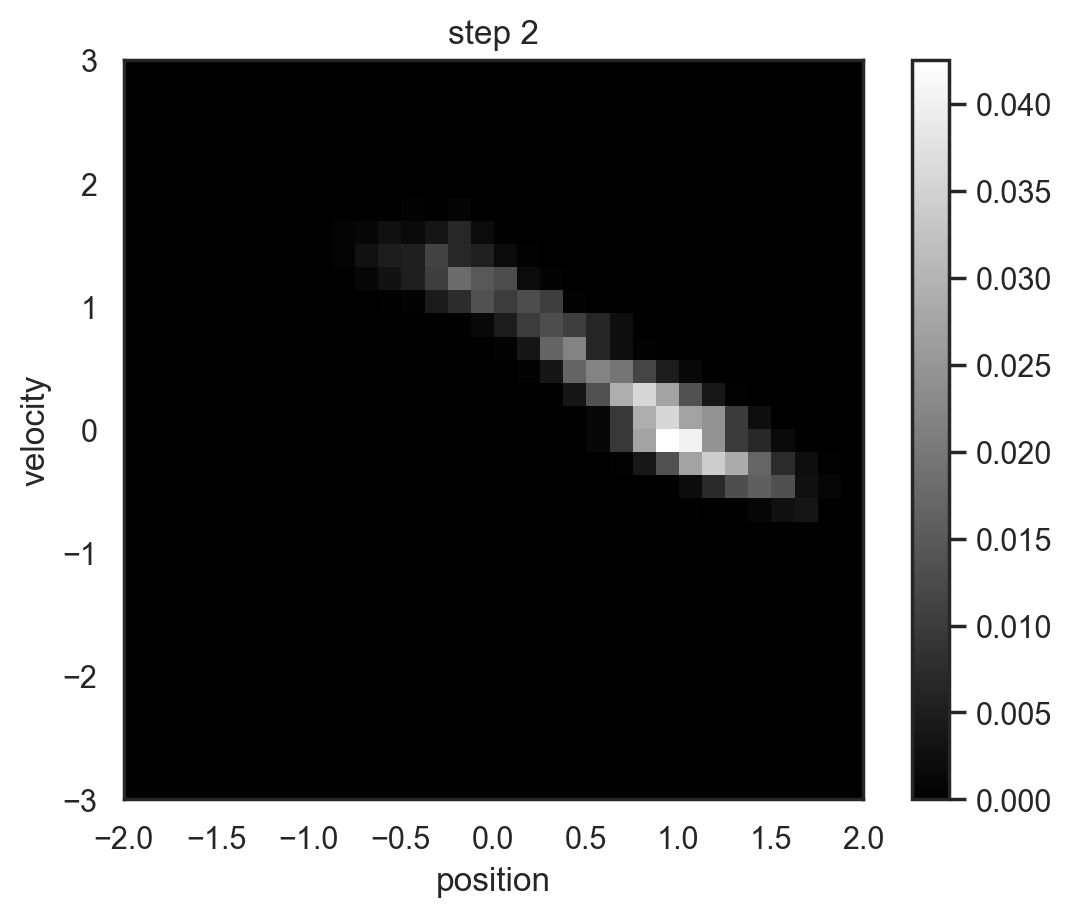

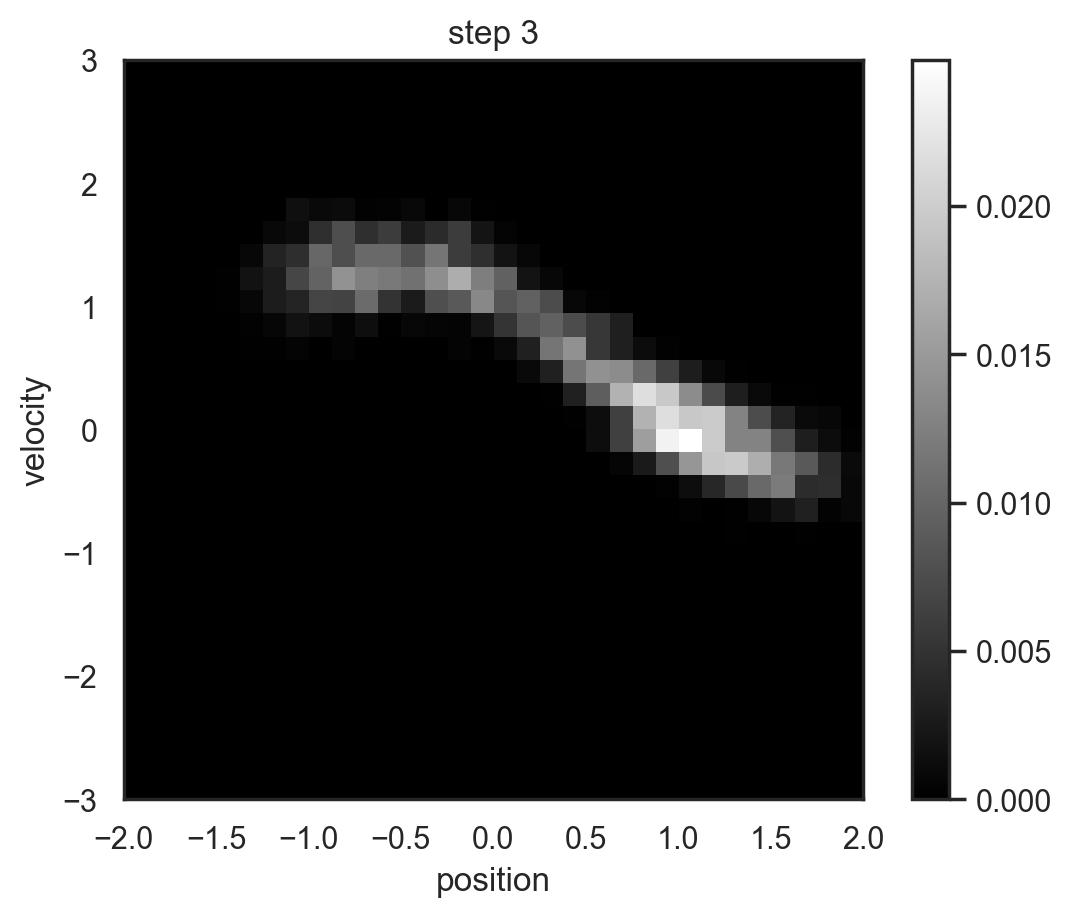

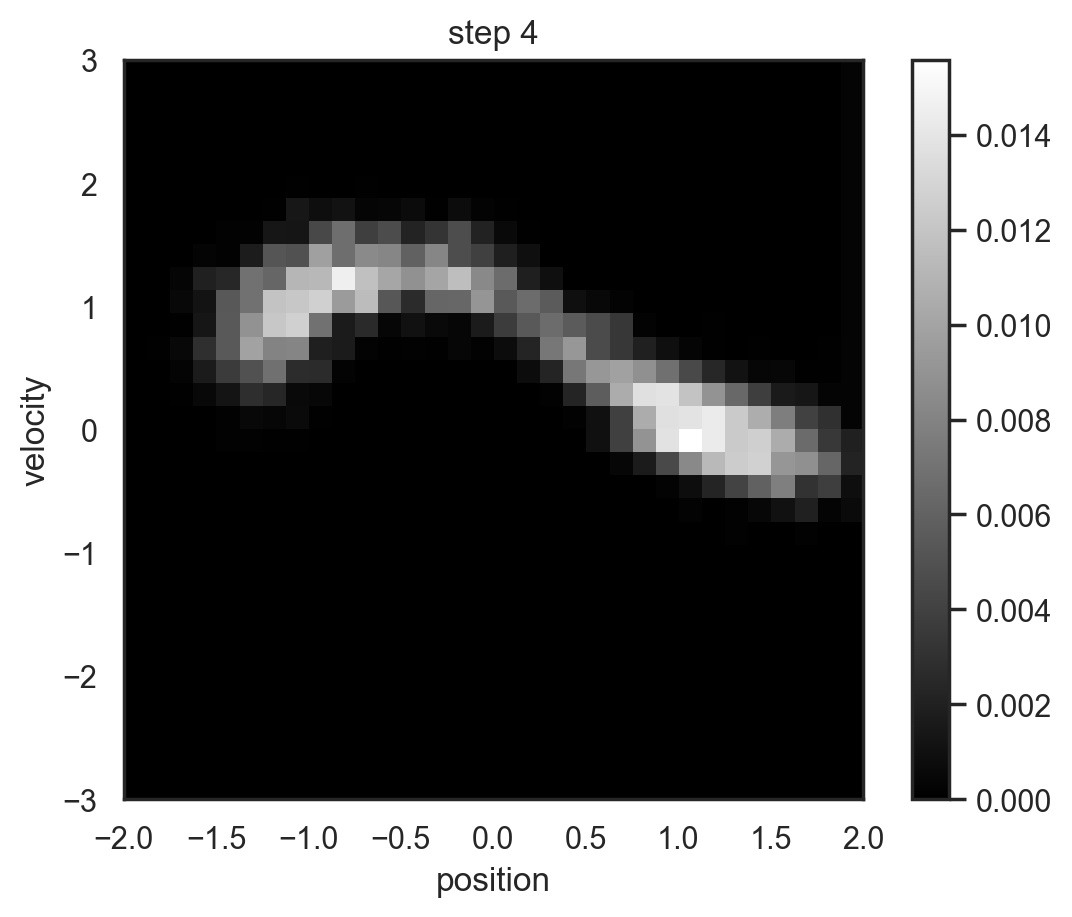

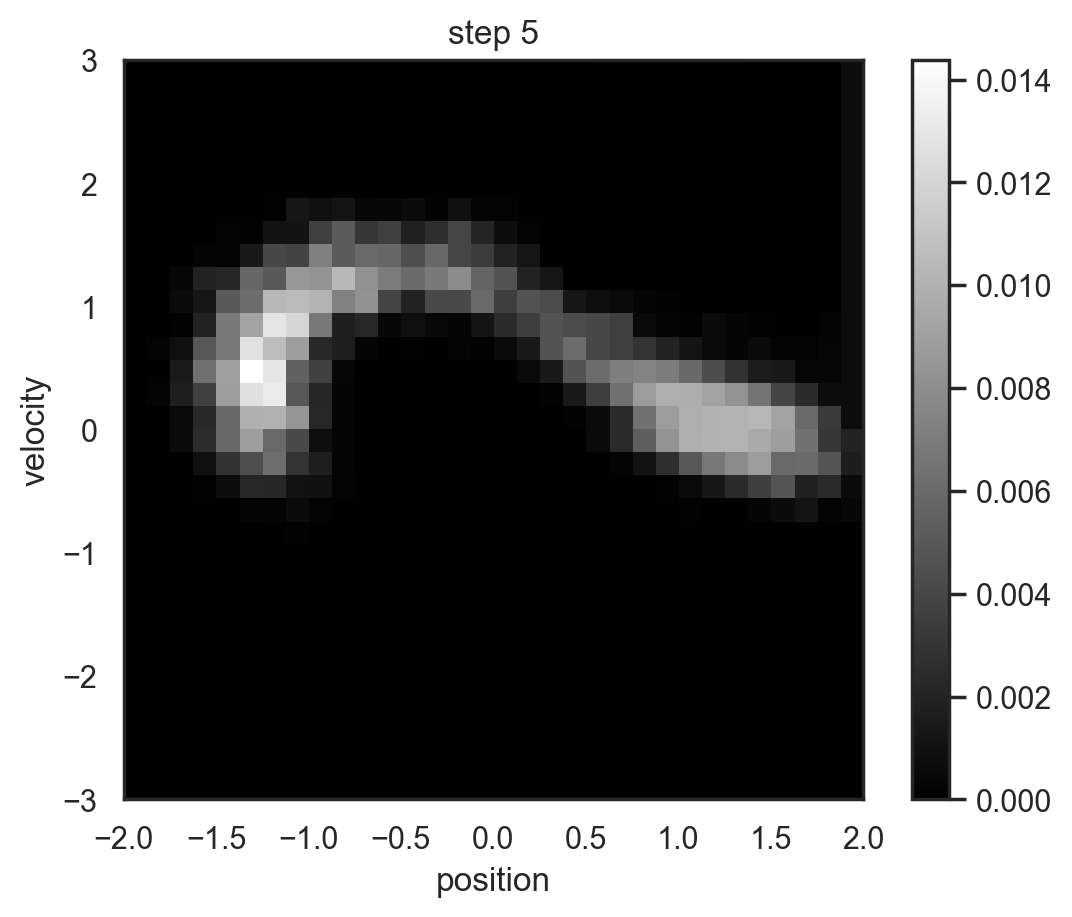

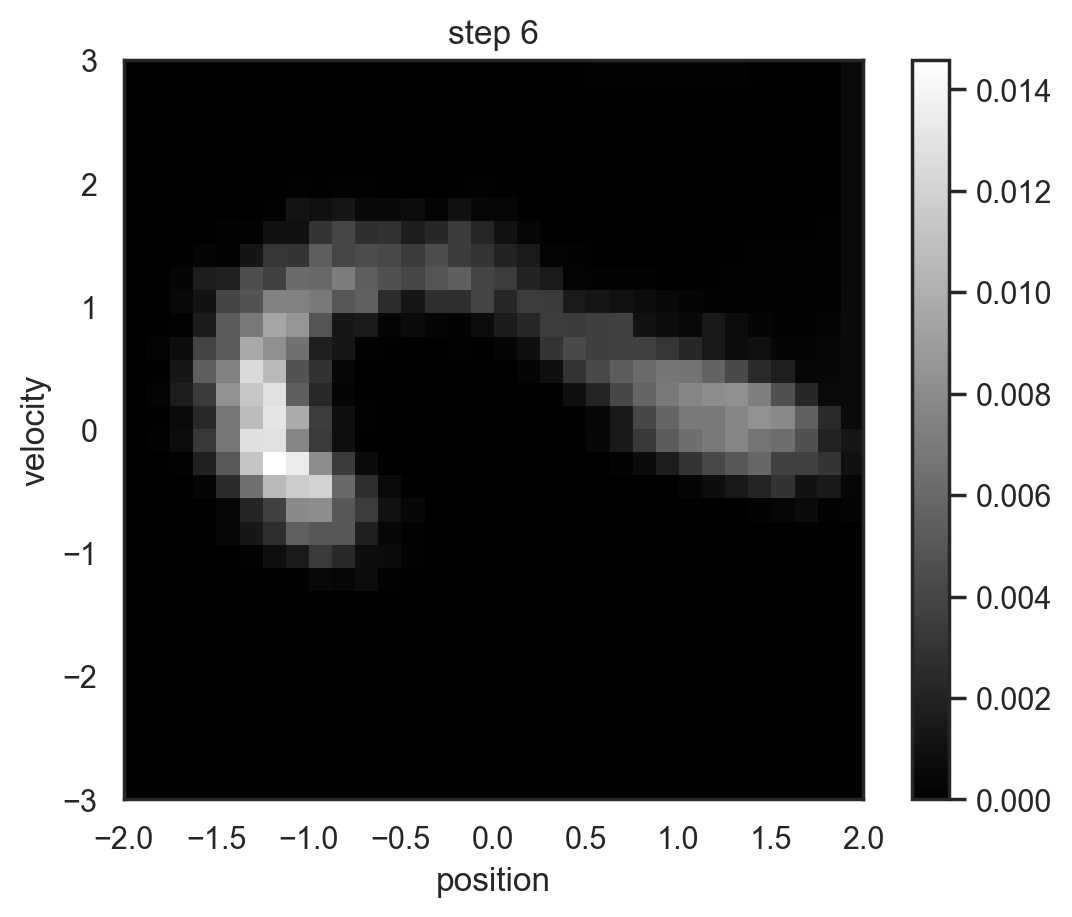

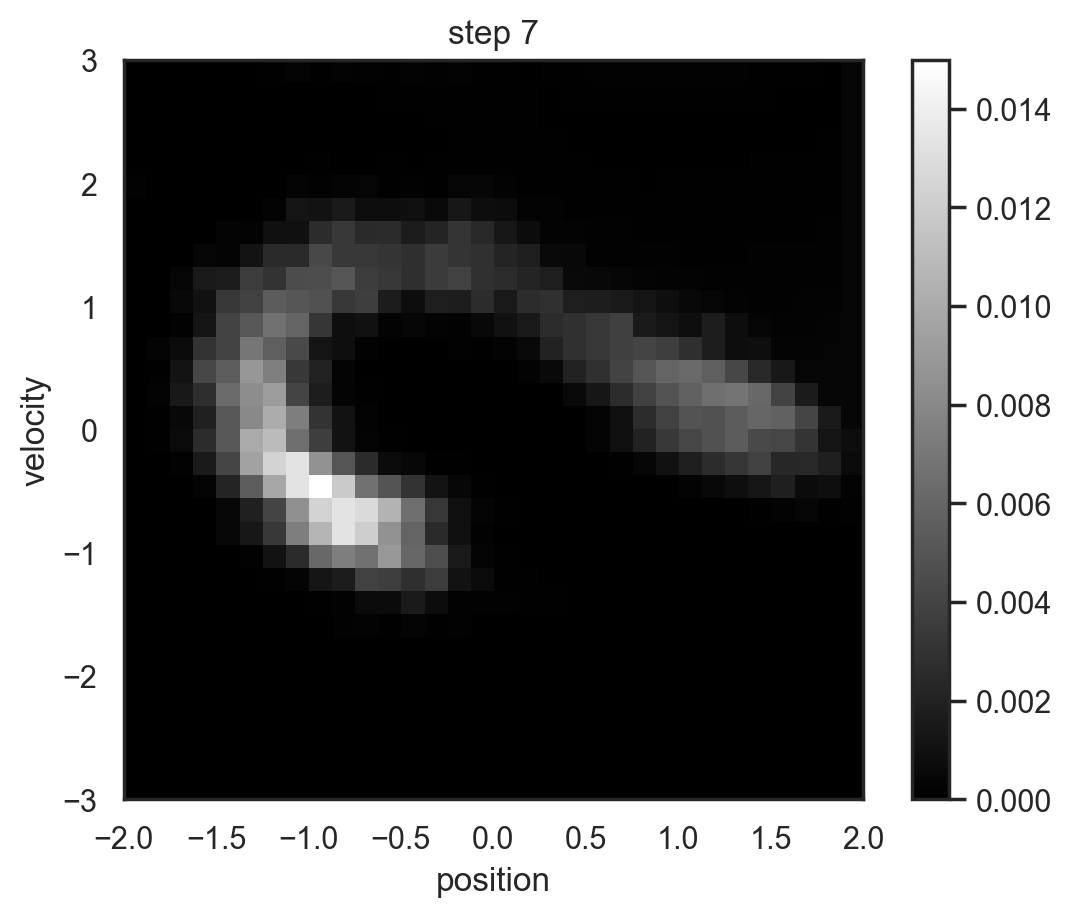

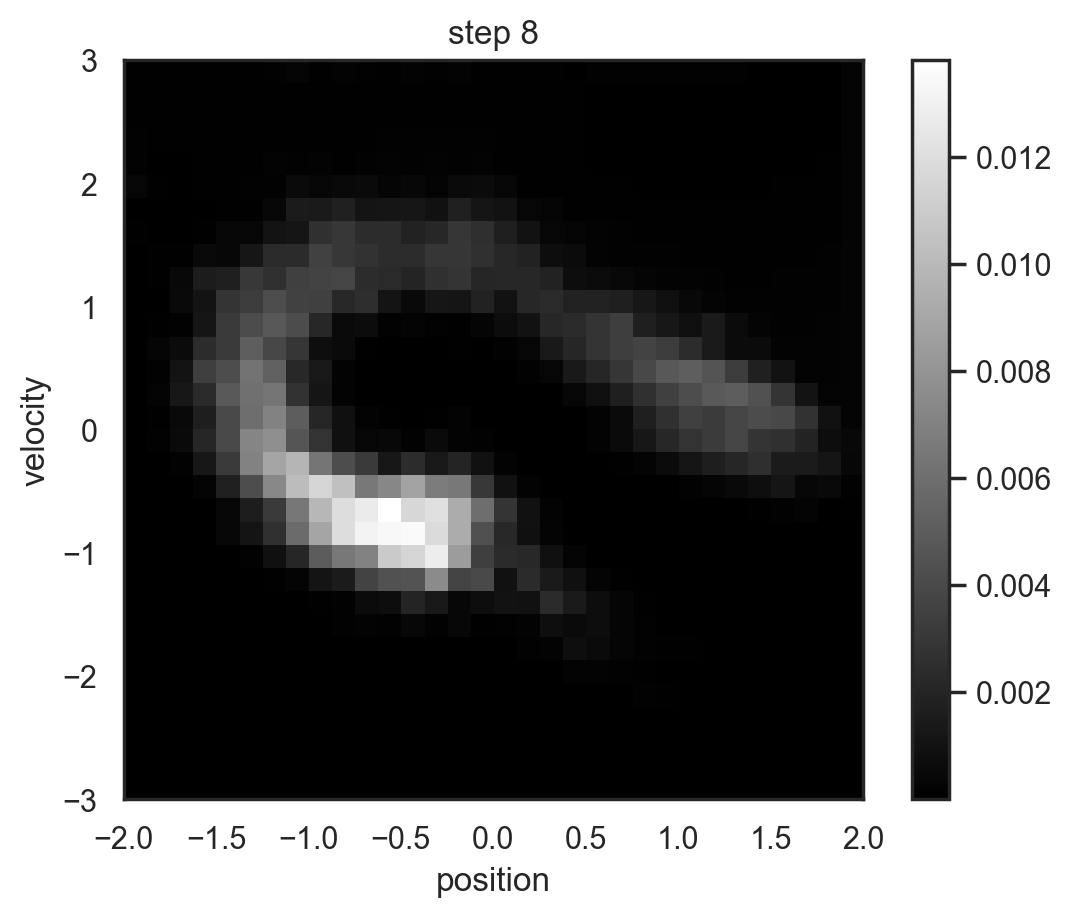

In [32]:
idx_act = 2

starting_motion = np.array([1.0, 0.0])

belief = np.zeros(n_state)
dist, idx = tree.query(starting_motion)
belief[idx] = 1

step = 0
for step in range(n_steps_variations[-1]+1):

    belief = np.dot(p_backward[idx_act], belief)
    # print(belief.sum())

    plot_belief(belief)
    plt.title(f"step {step}")
    step += 1

### Testing going forward

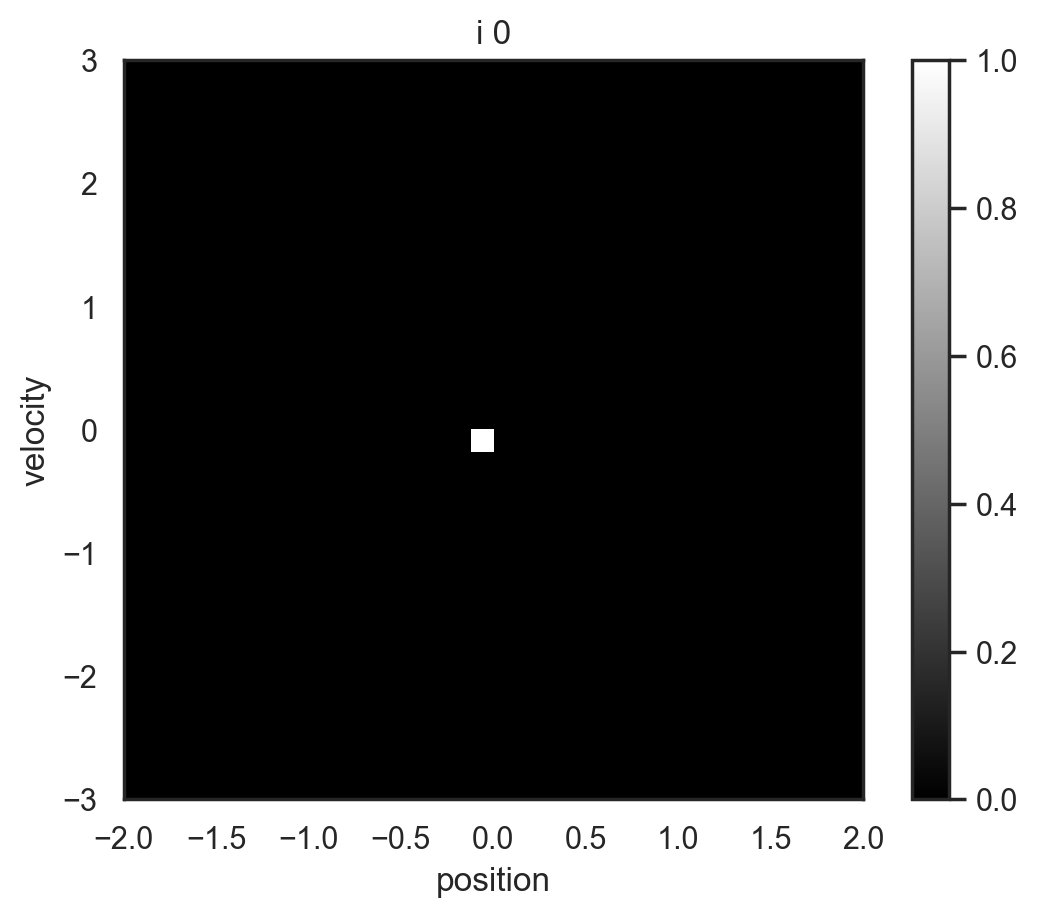

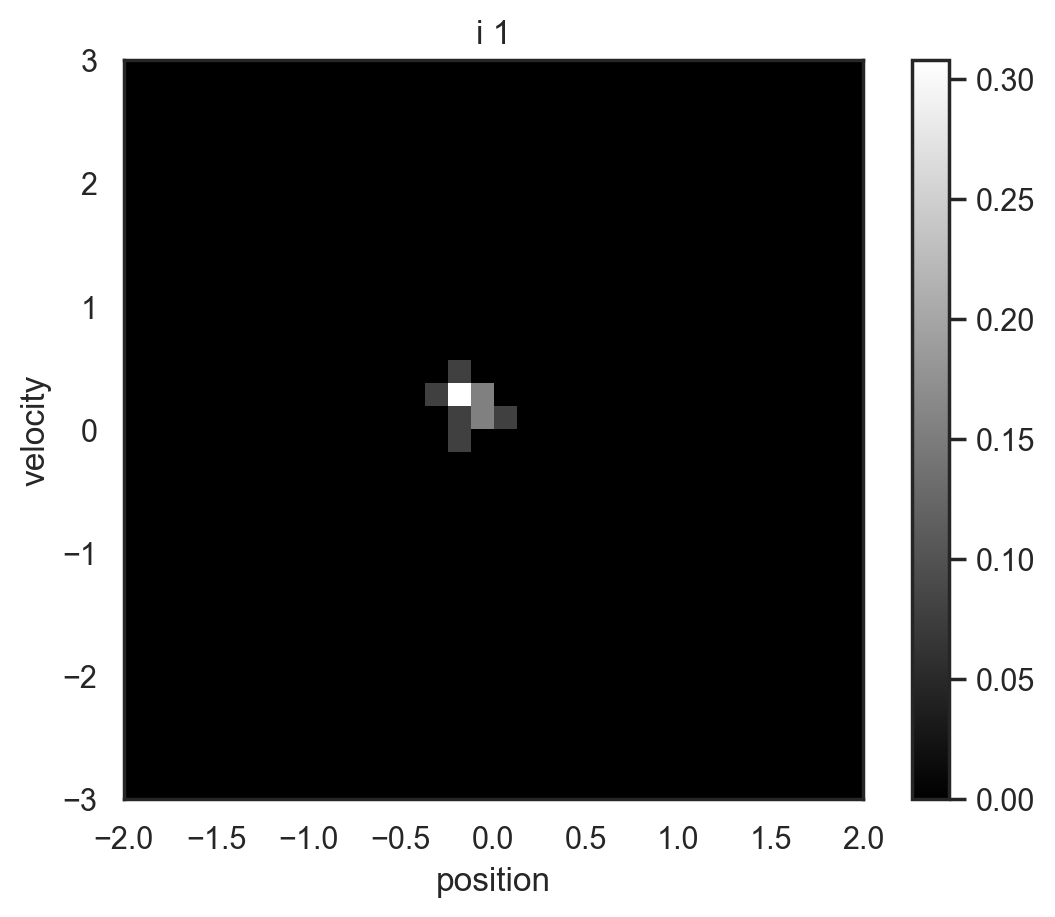

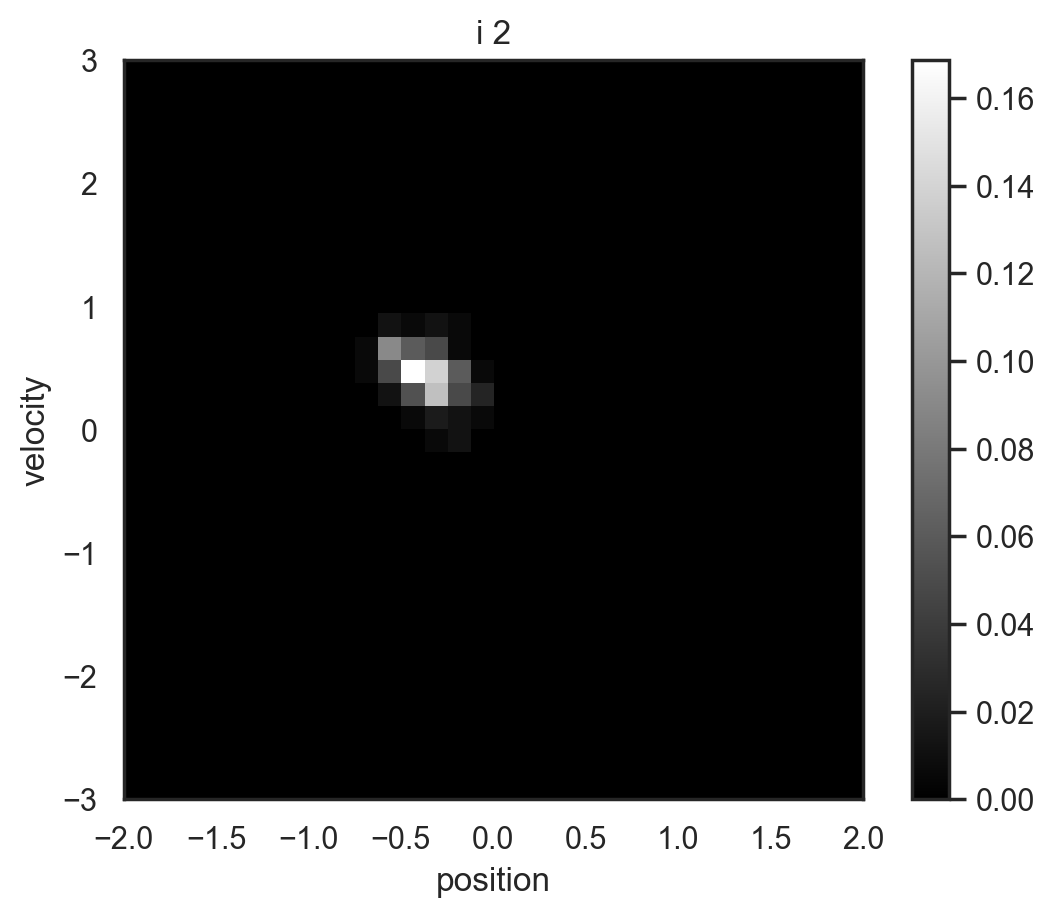

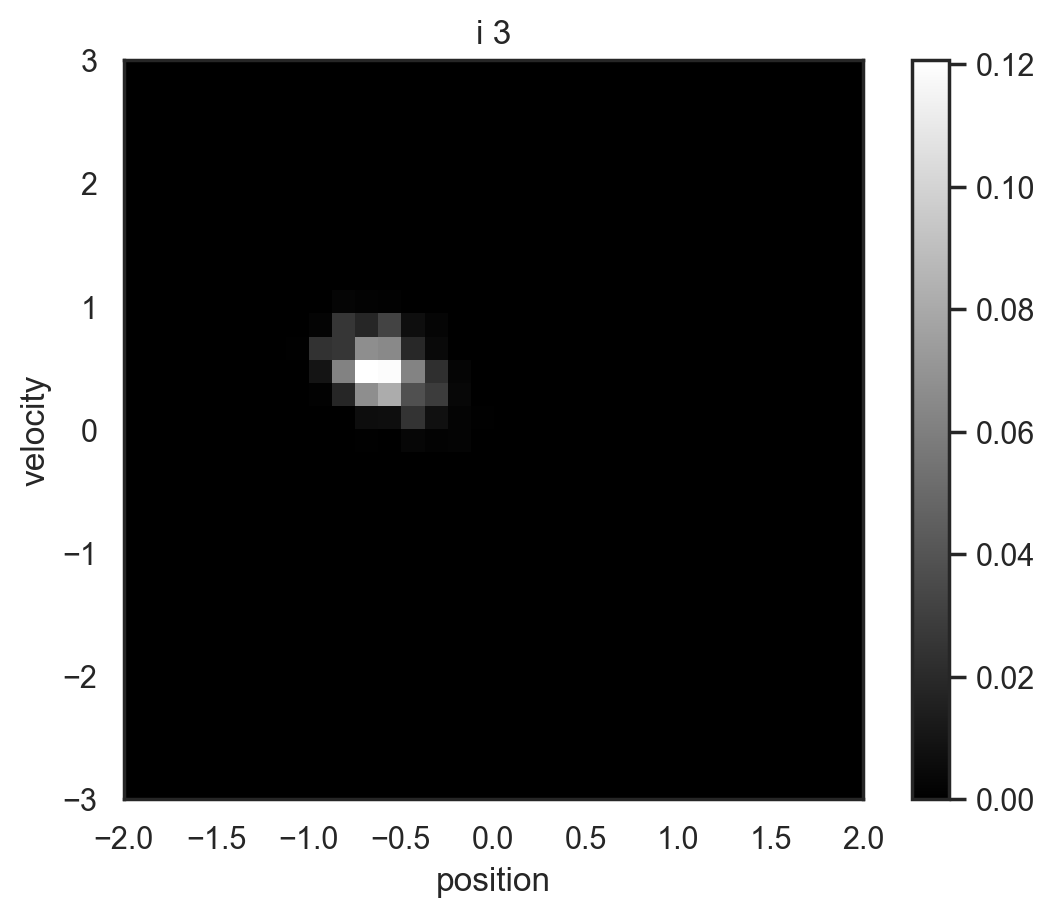

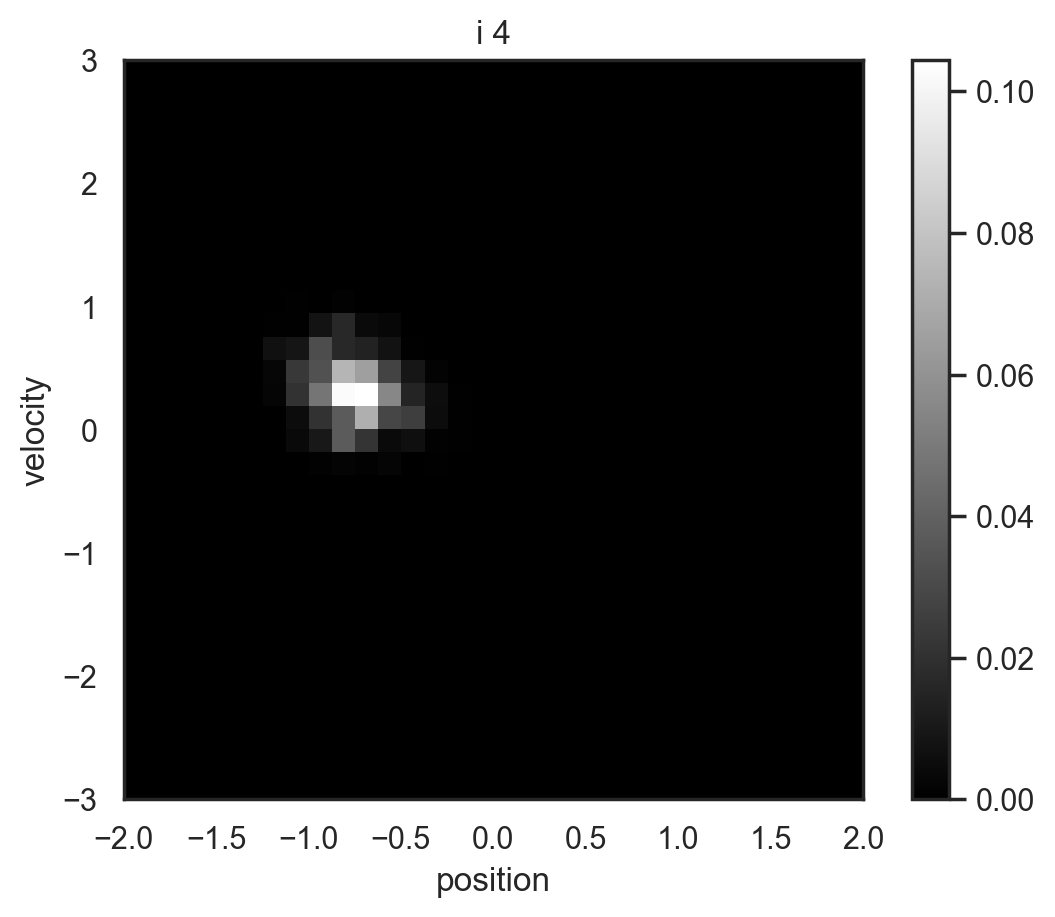

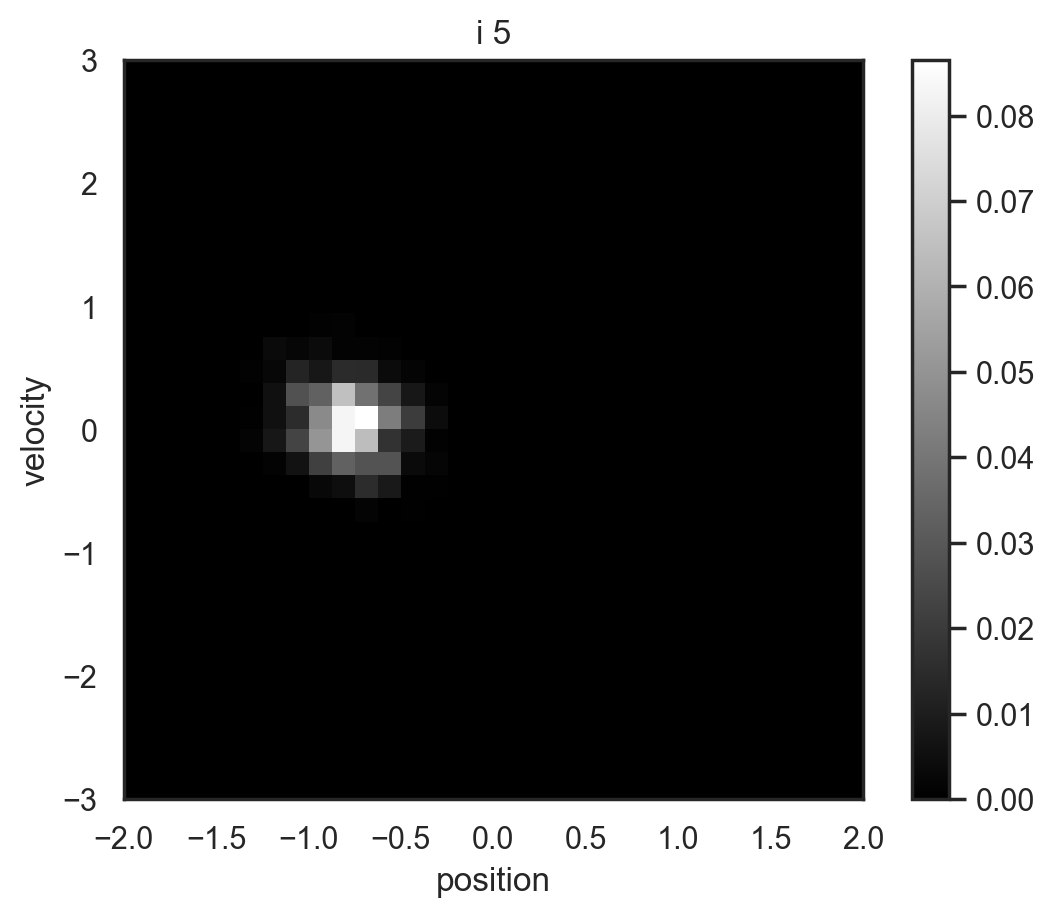

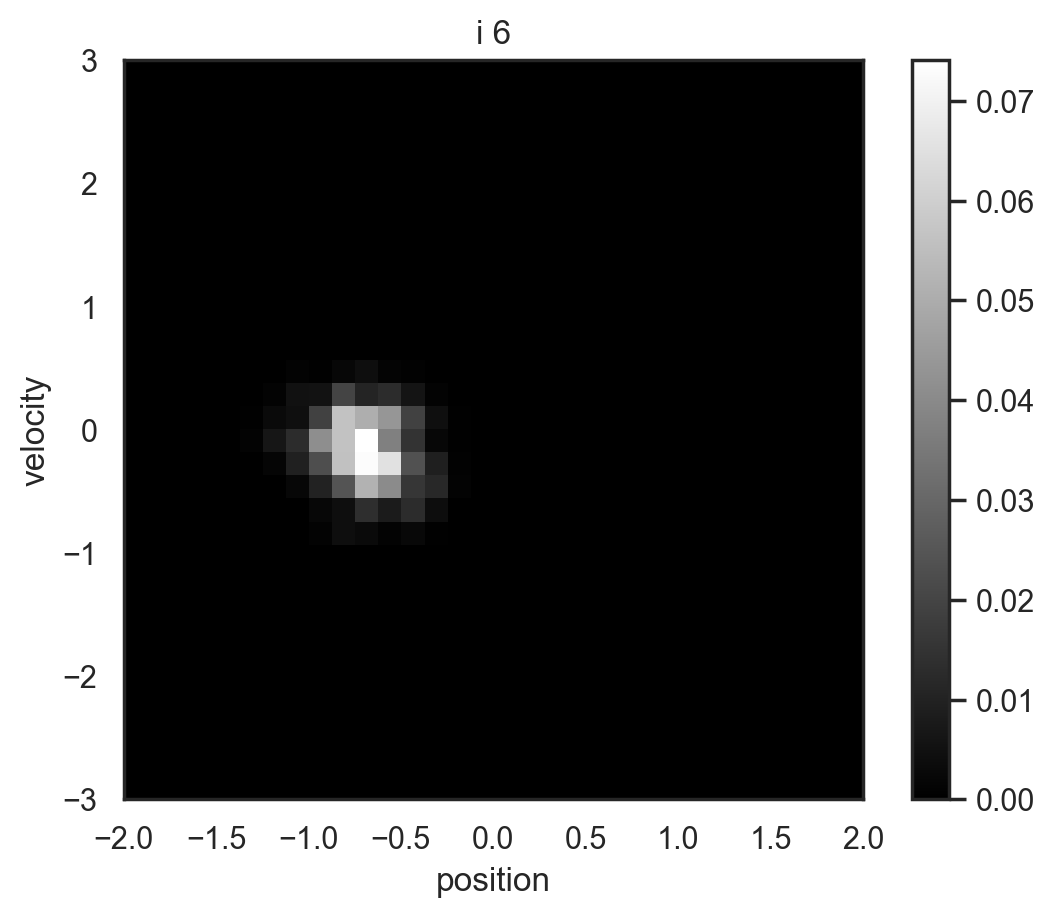

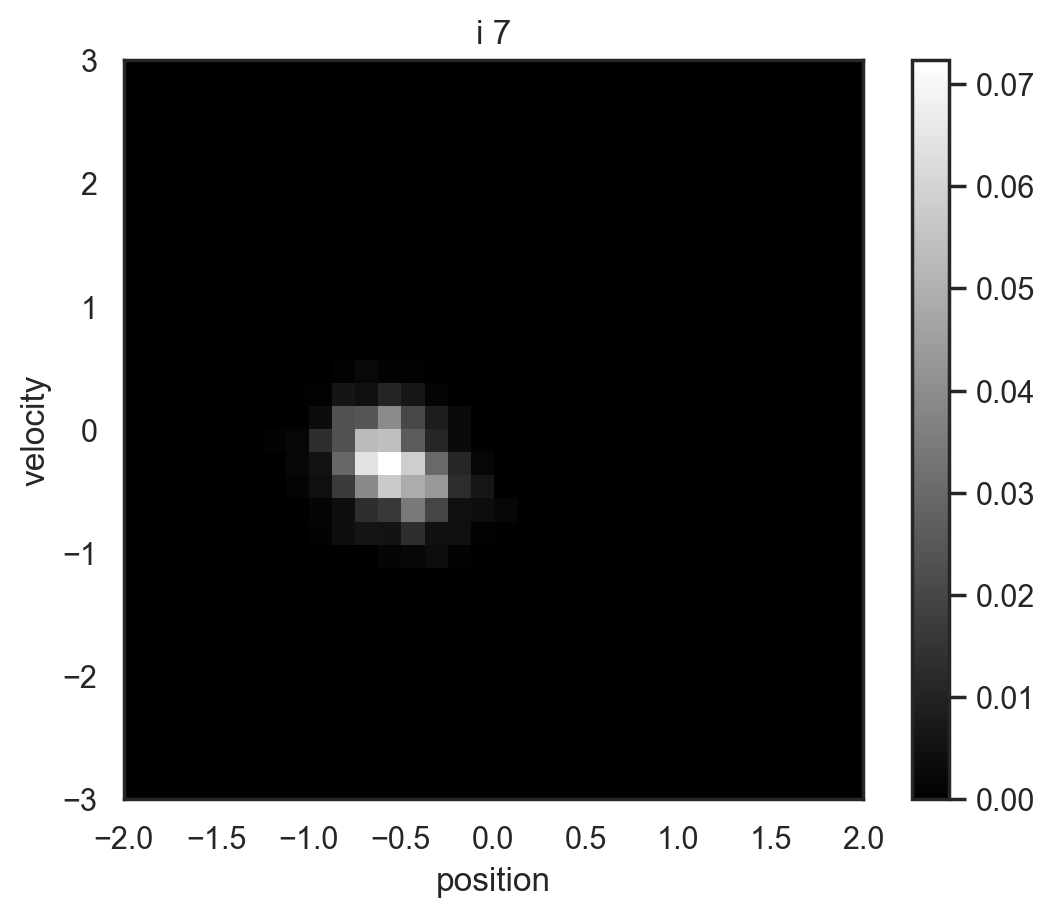

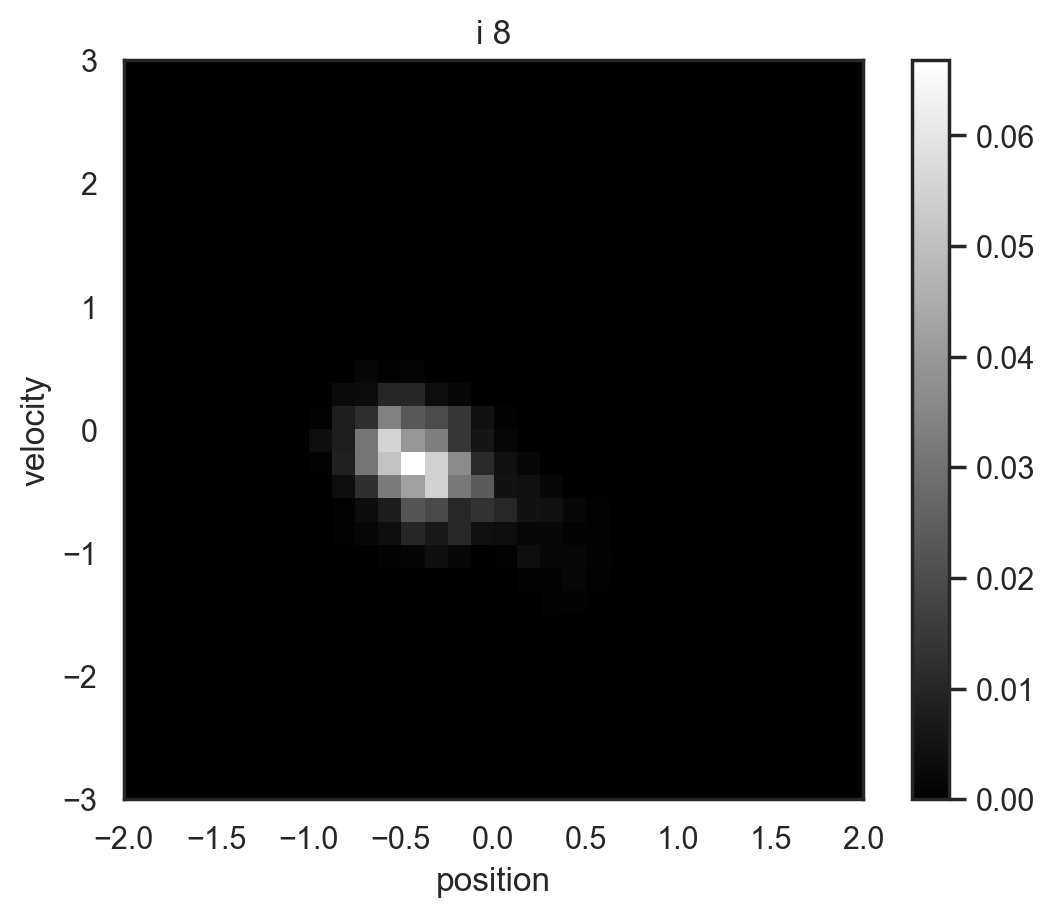

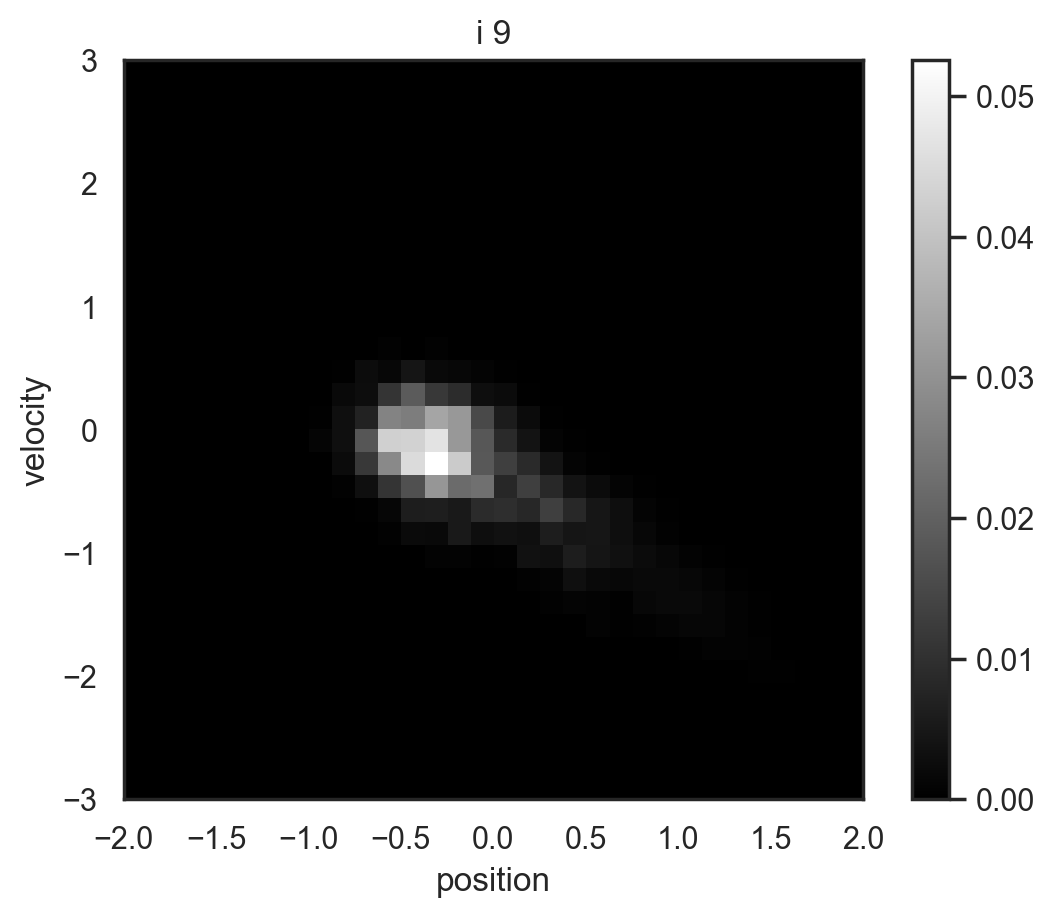

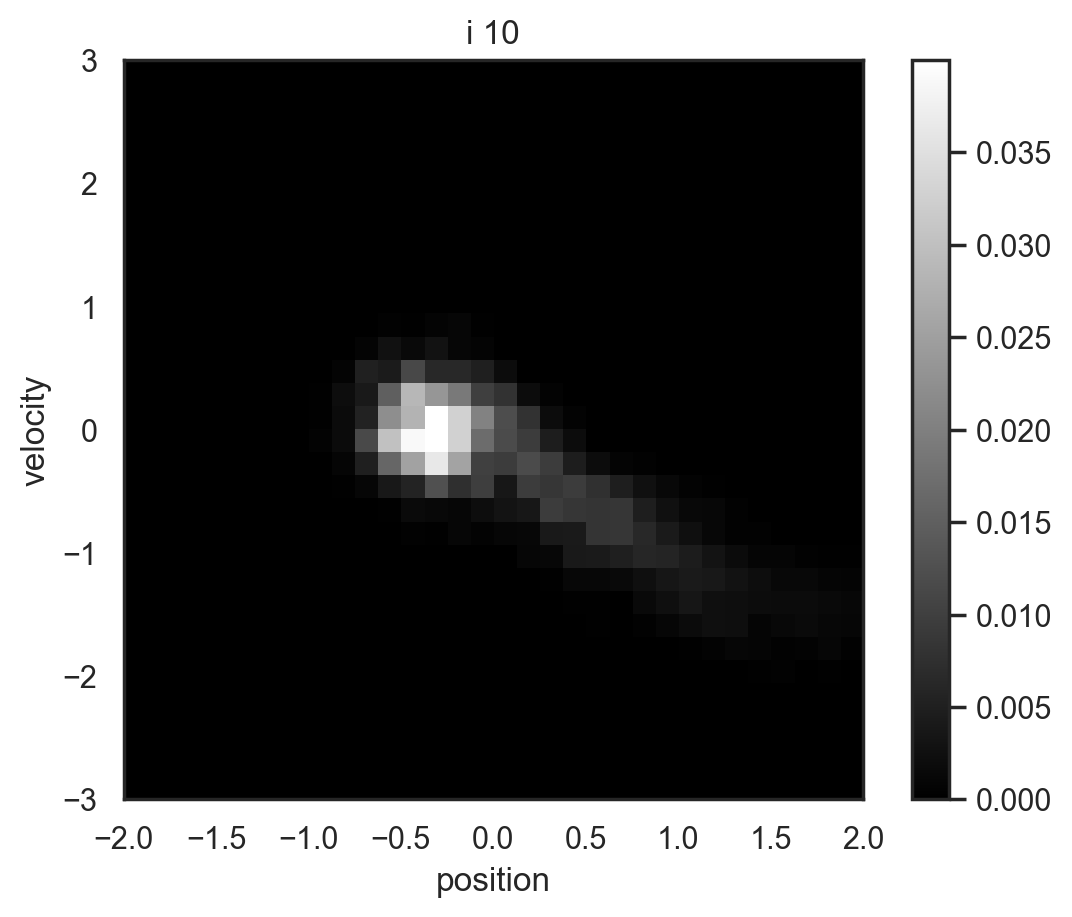

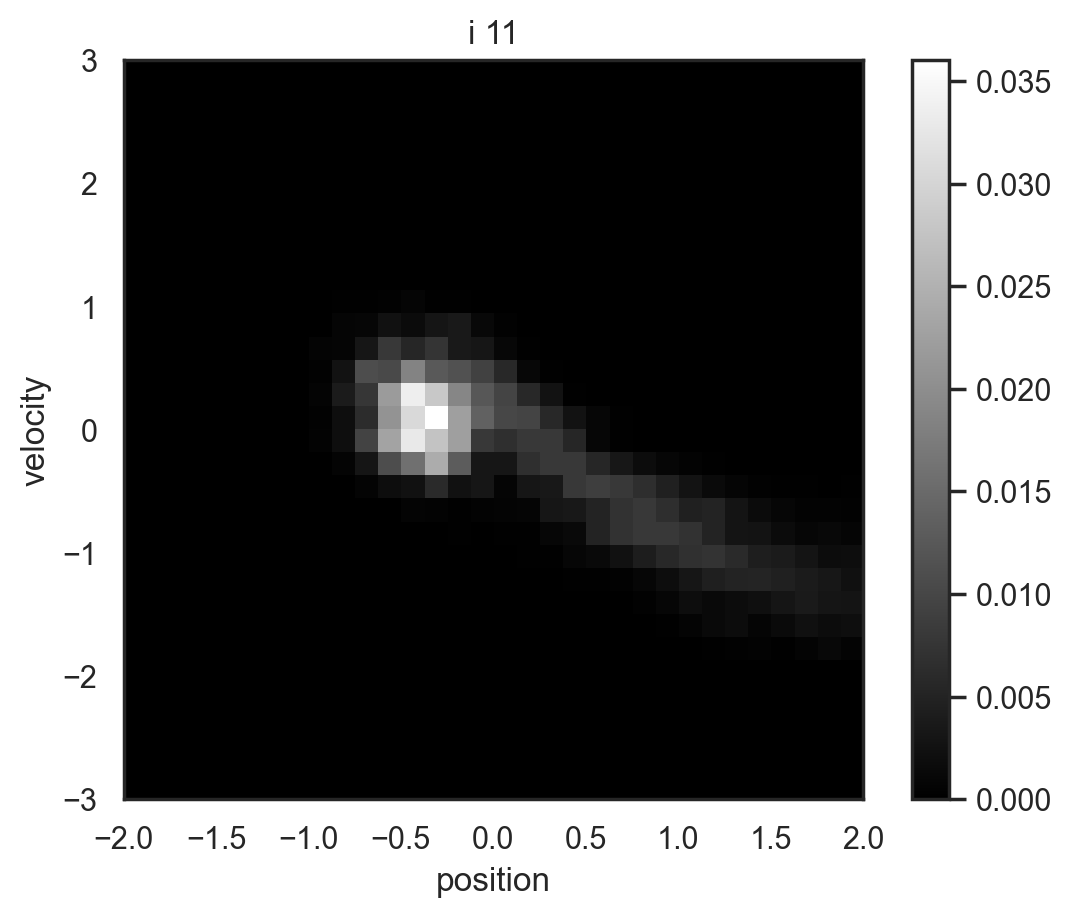

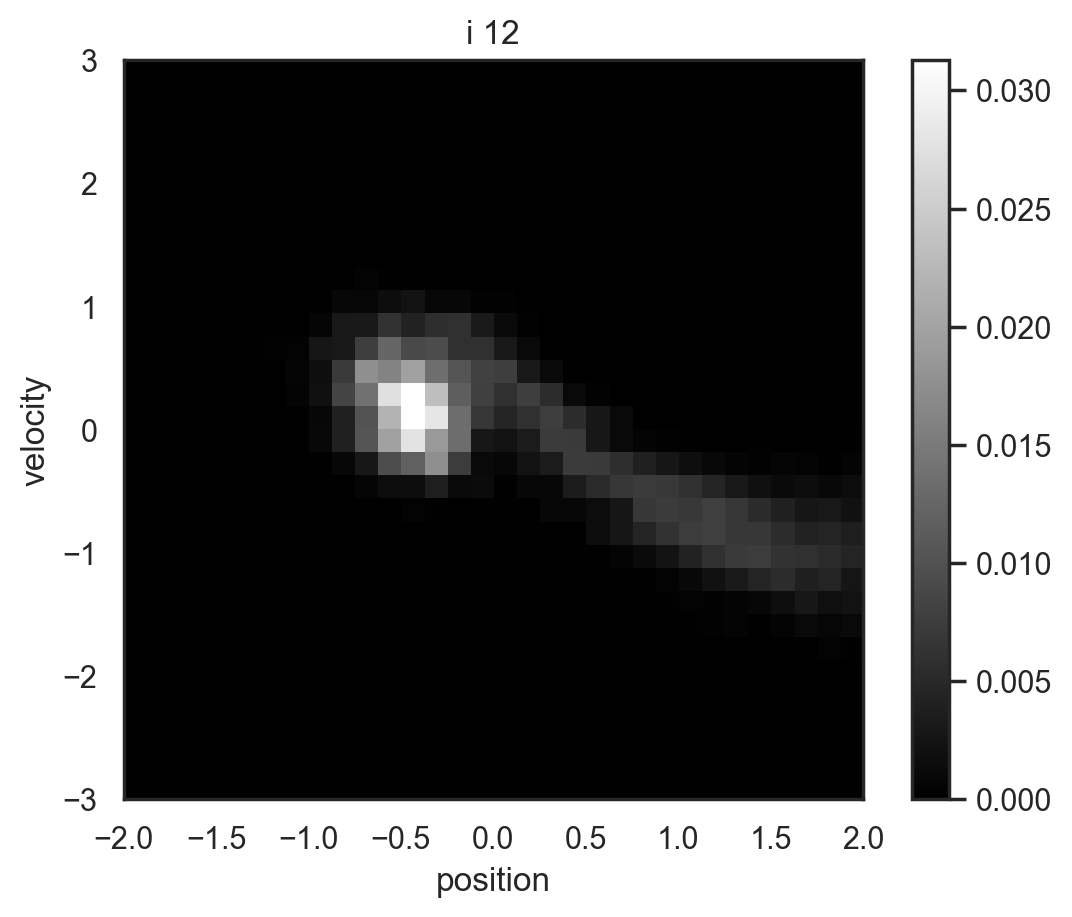

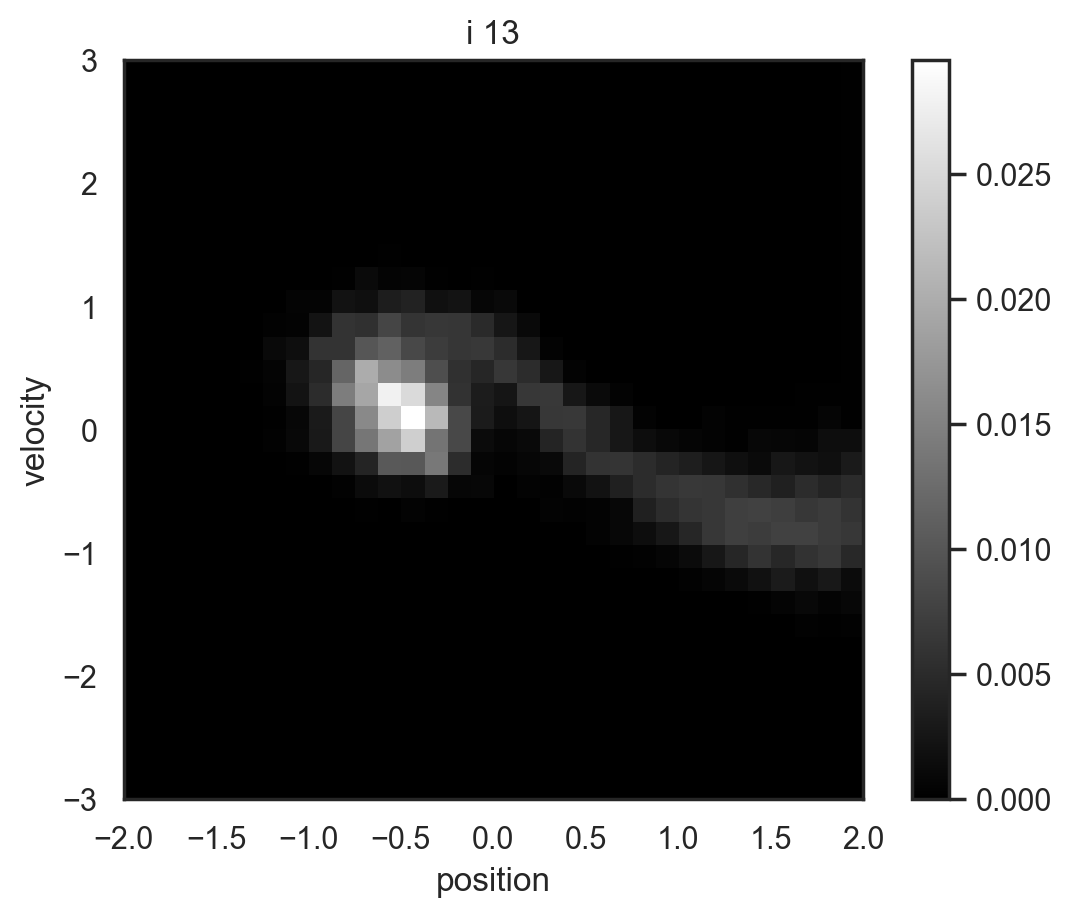

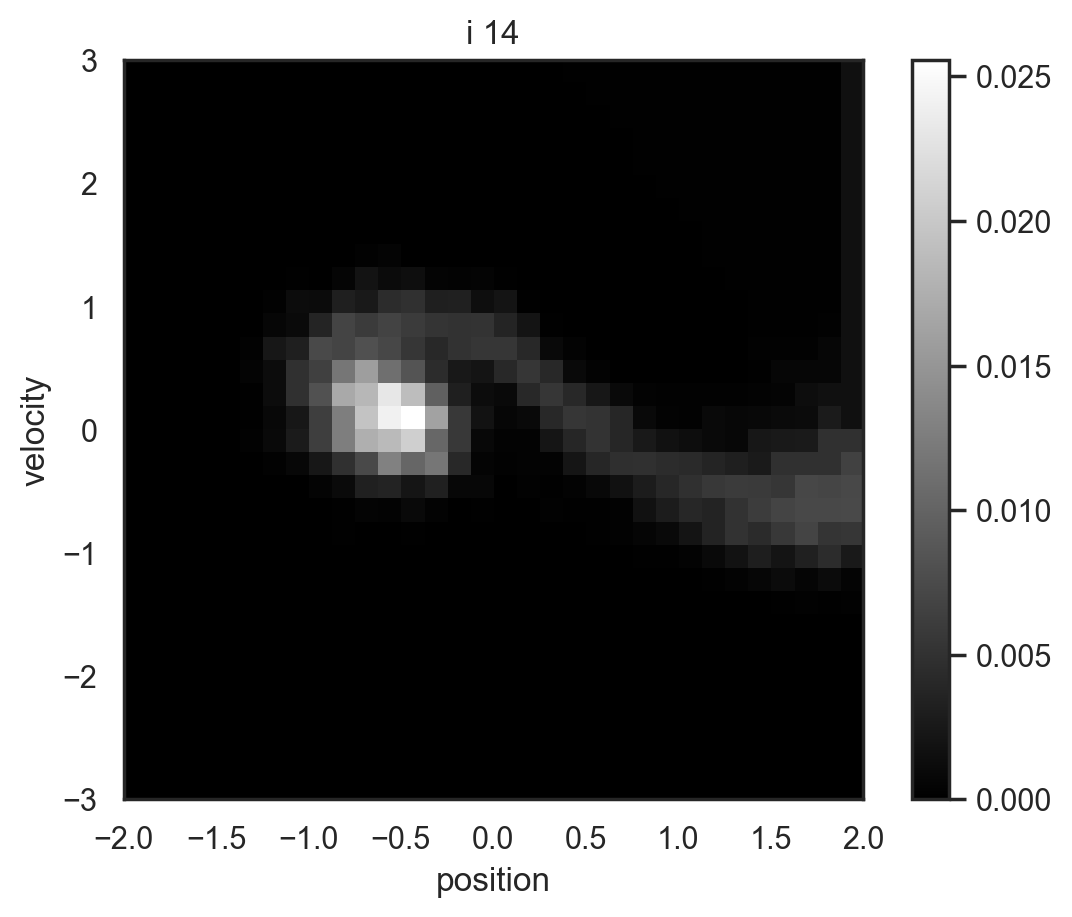

In [67]:
belief = np.zeros(n_state)
belief[starting_idx] = 1. # Encode the goal

idx_act = 2

i = 0
for t in range(n_step-1):
    
    plot_belief(belief)
    plt.title(f"i {i}")
    
    belief = np.dot(p_forward[idx_act], belief)  # np.dot(belief, p_backward[idx_act])
    belief /= belief.sum()
    i += 1

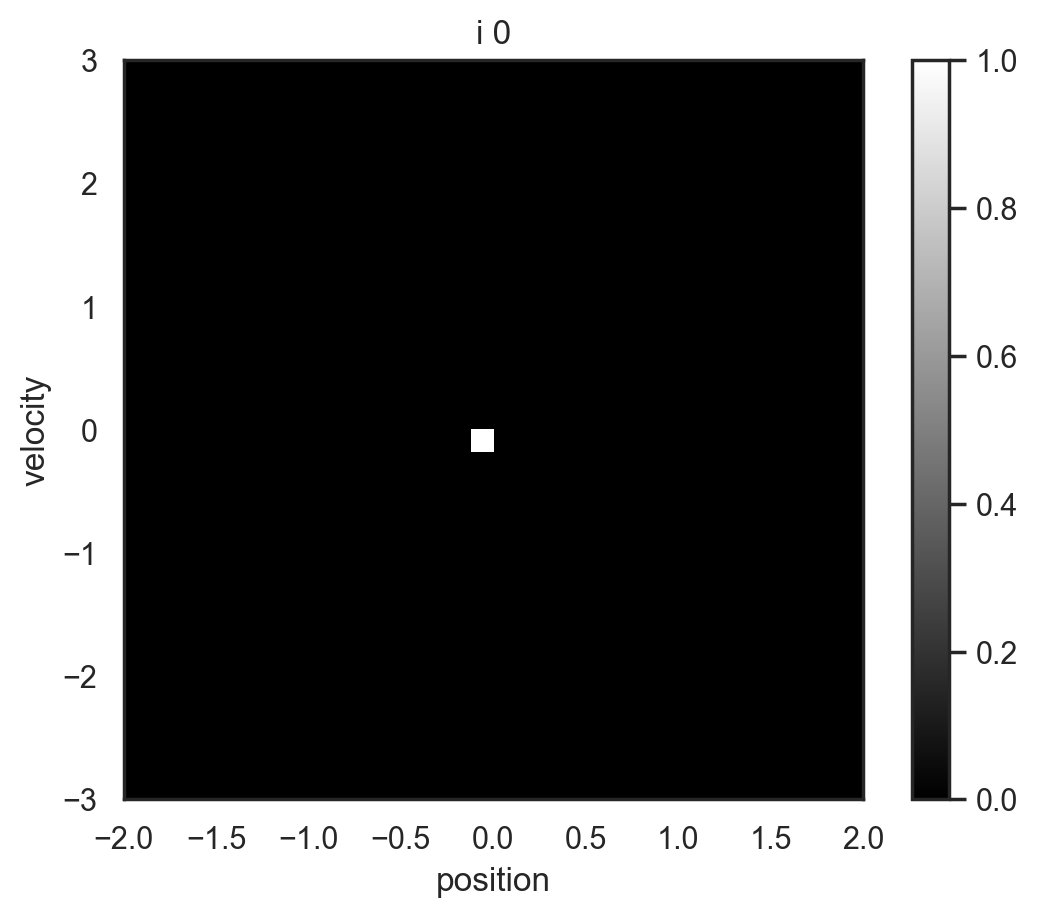

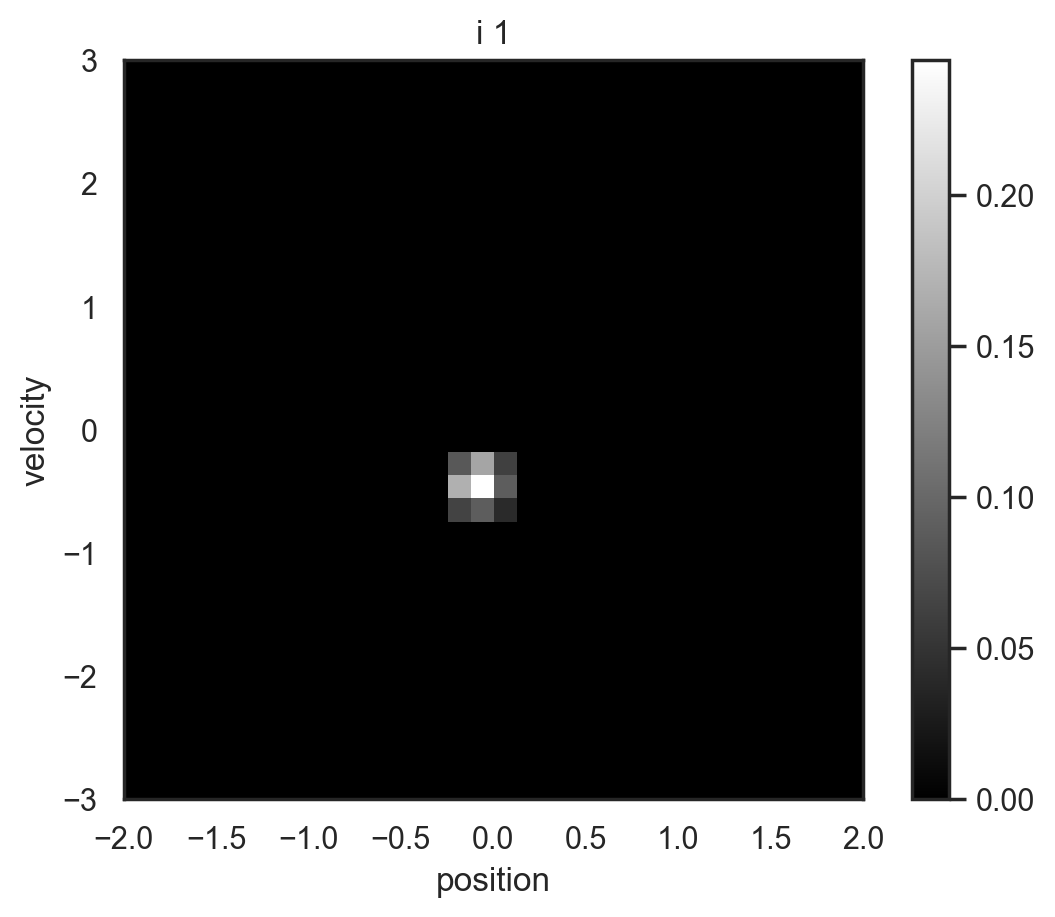

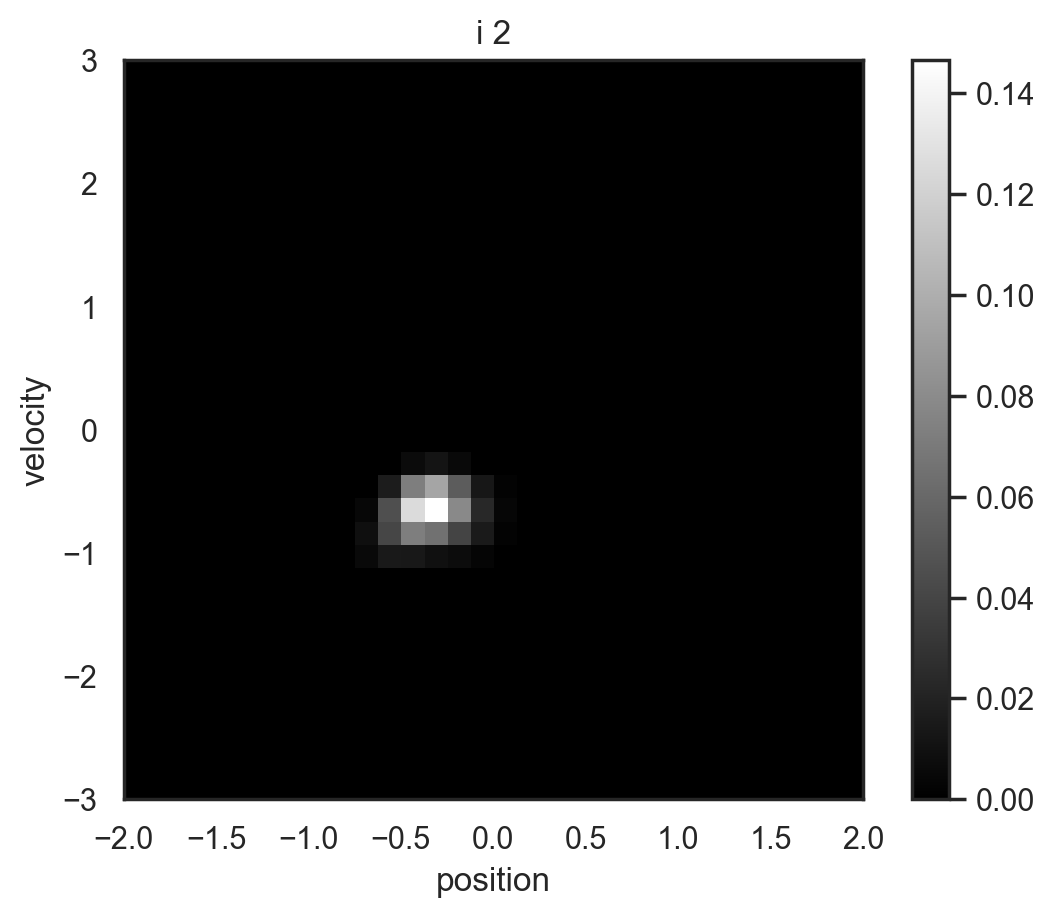

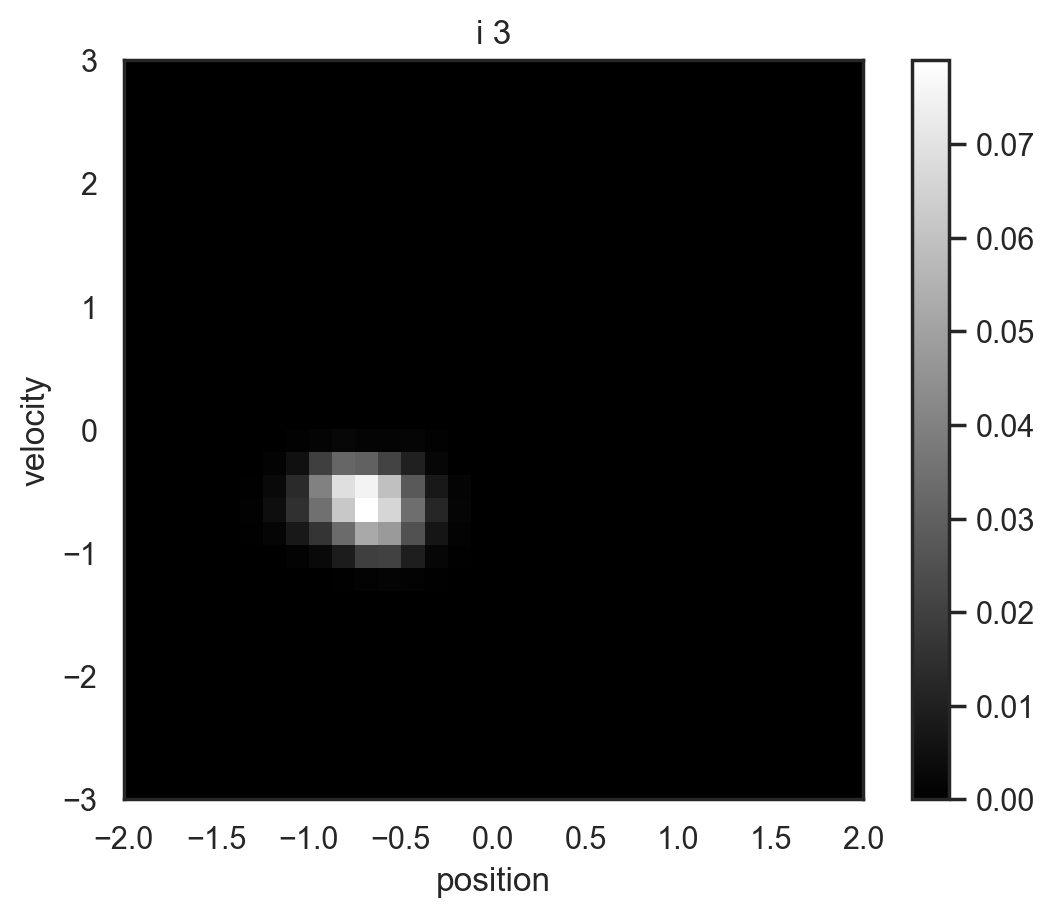

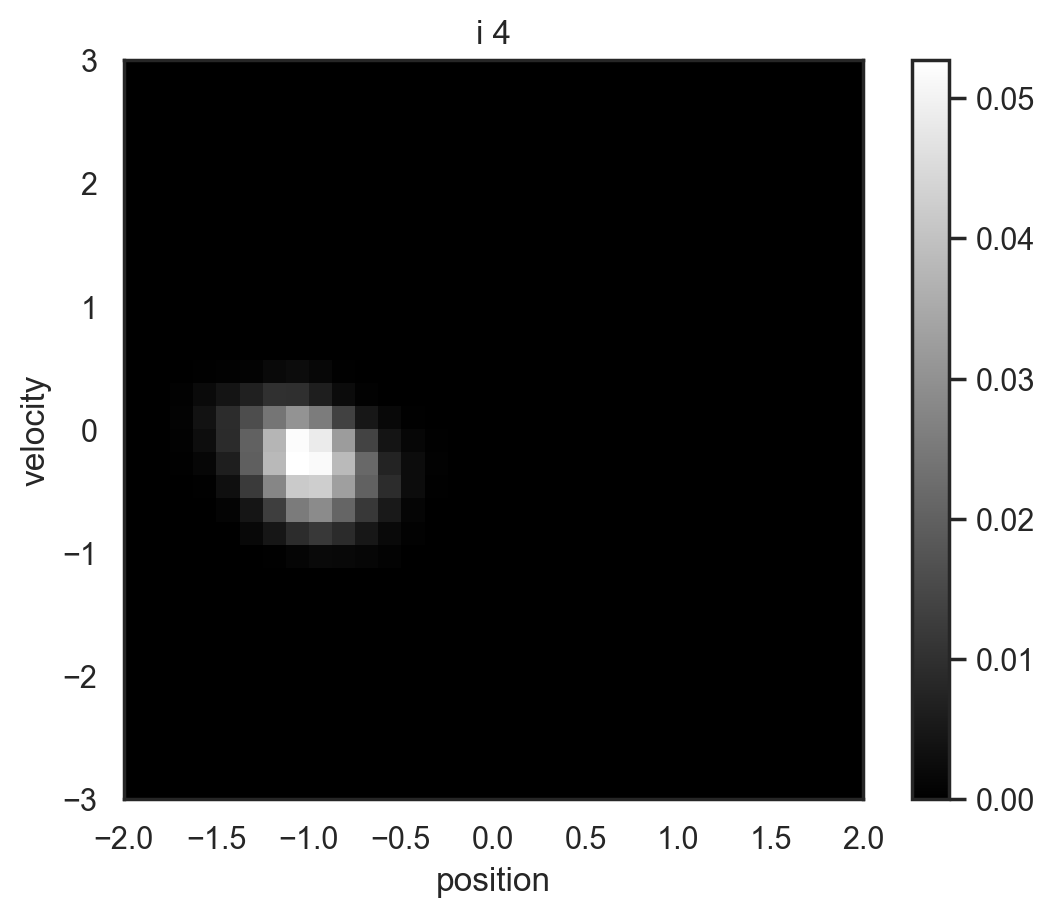

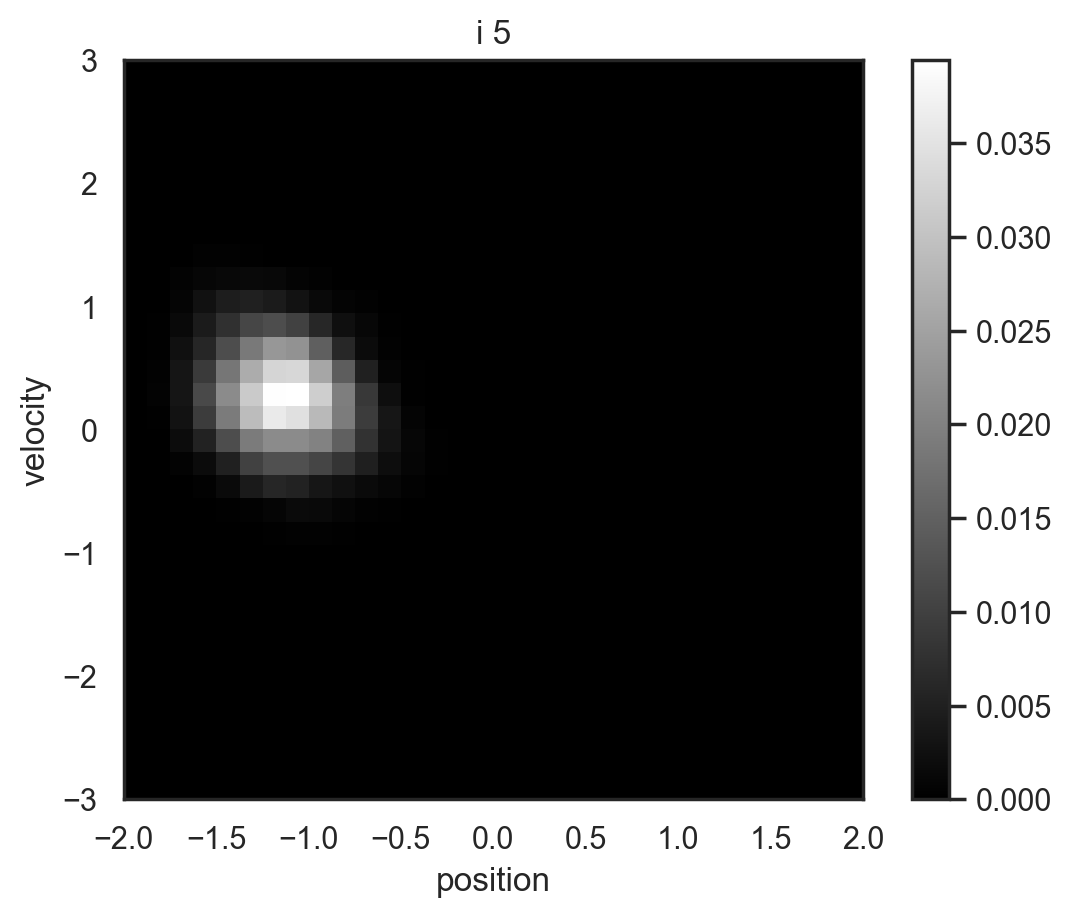

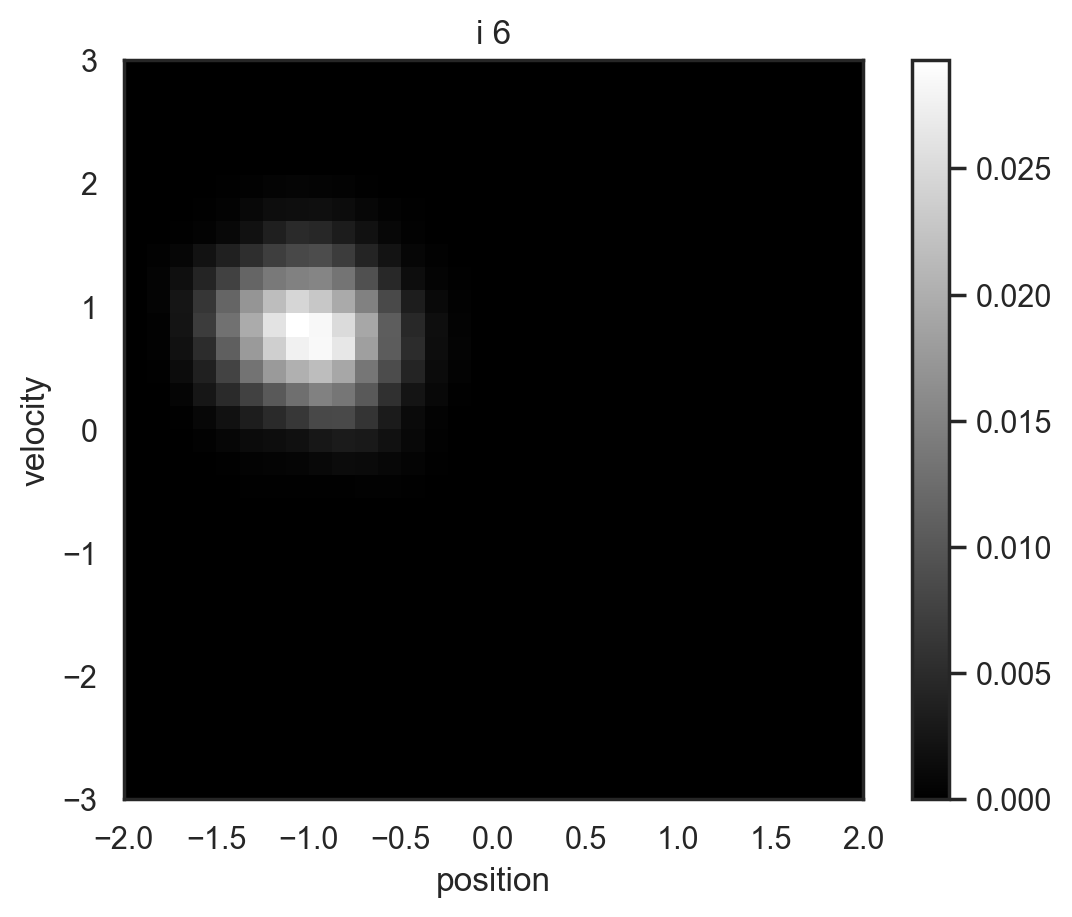

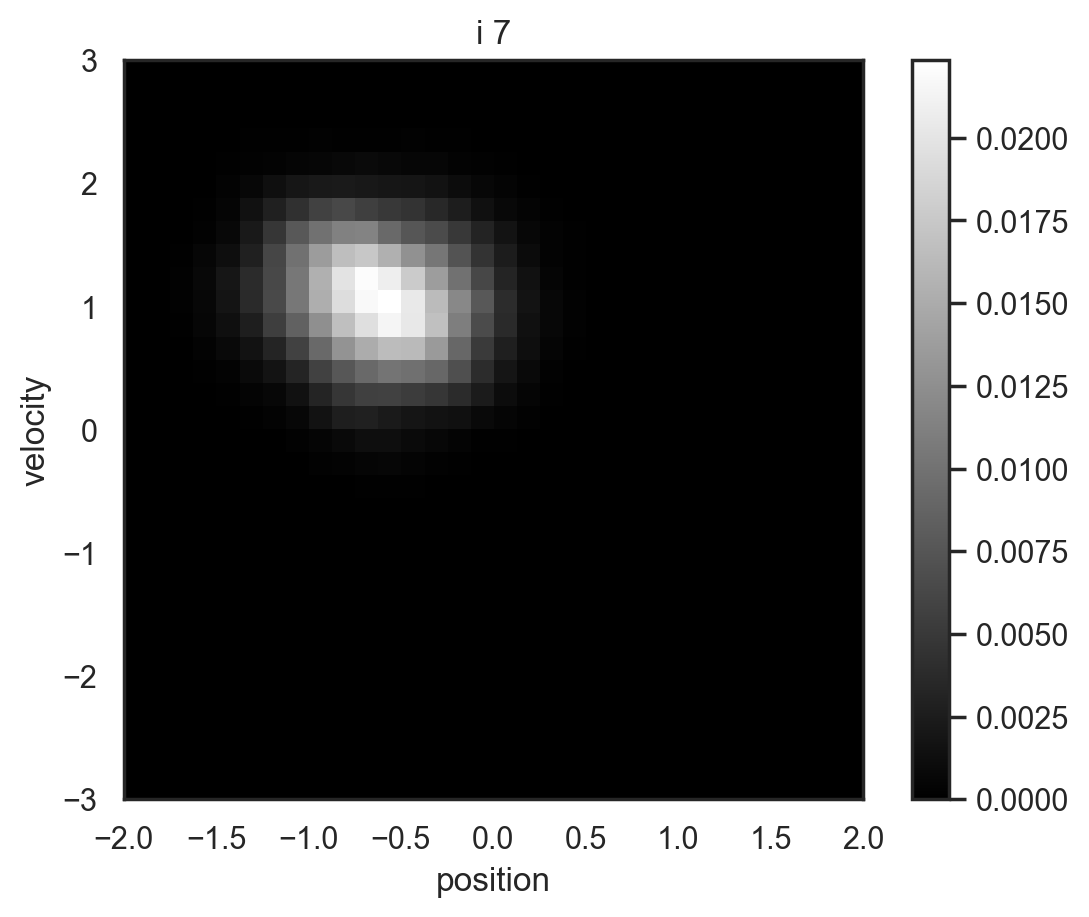

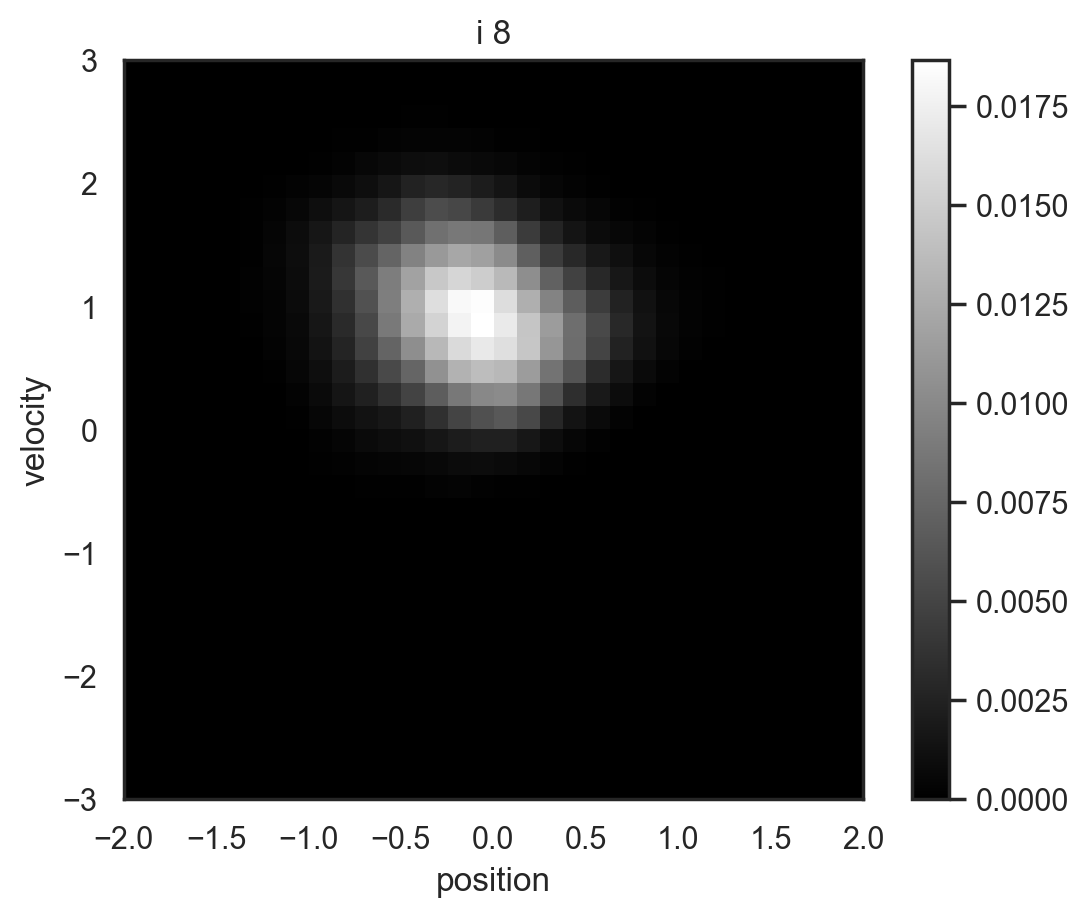

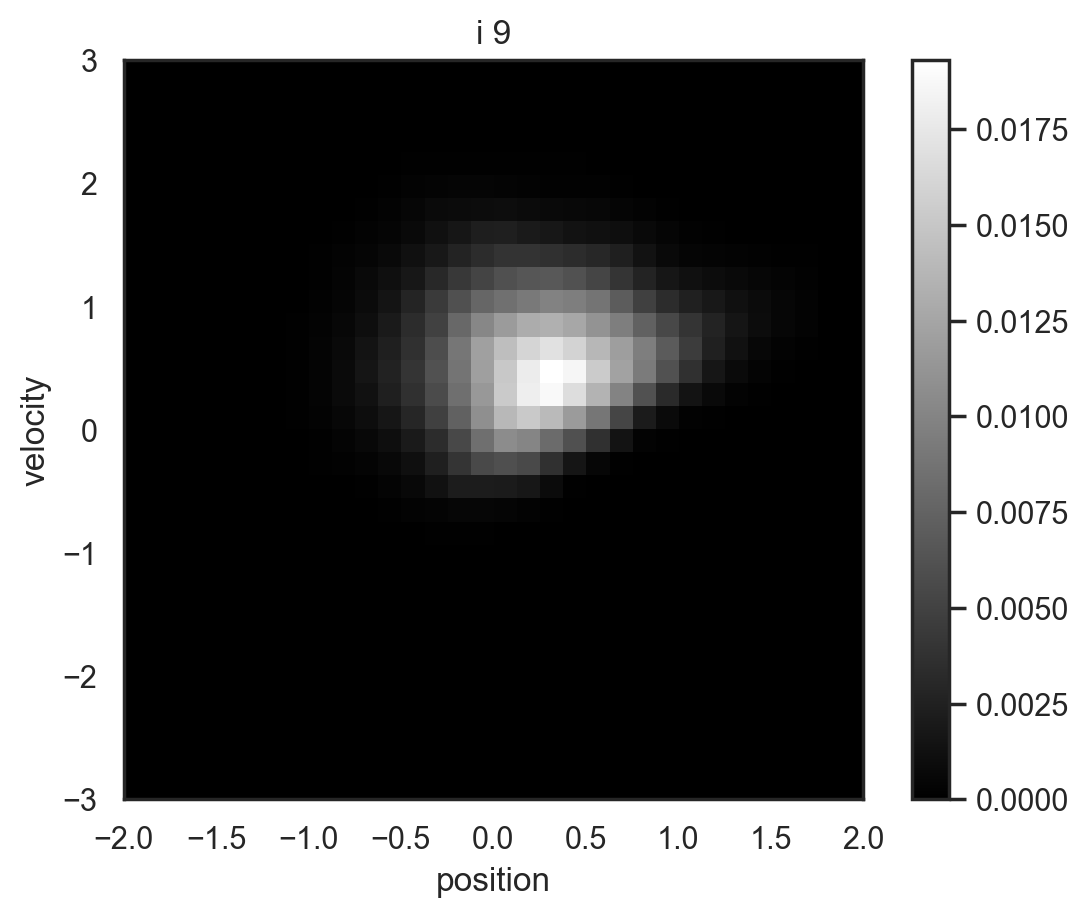

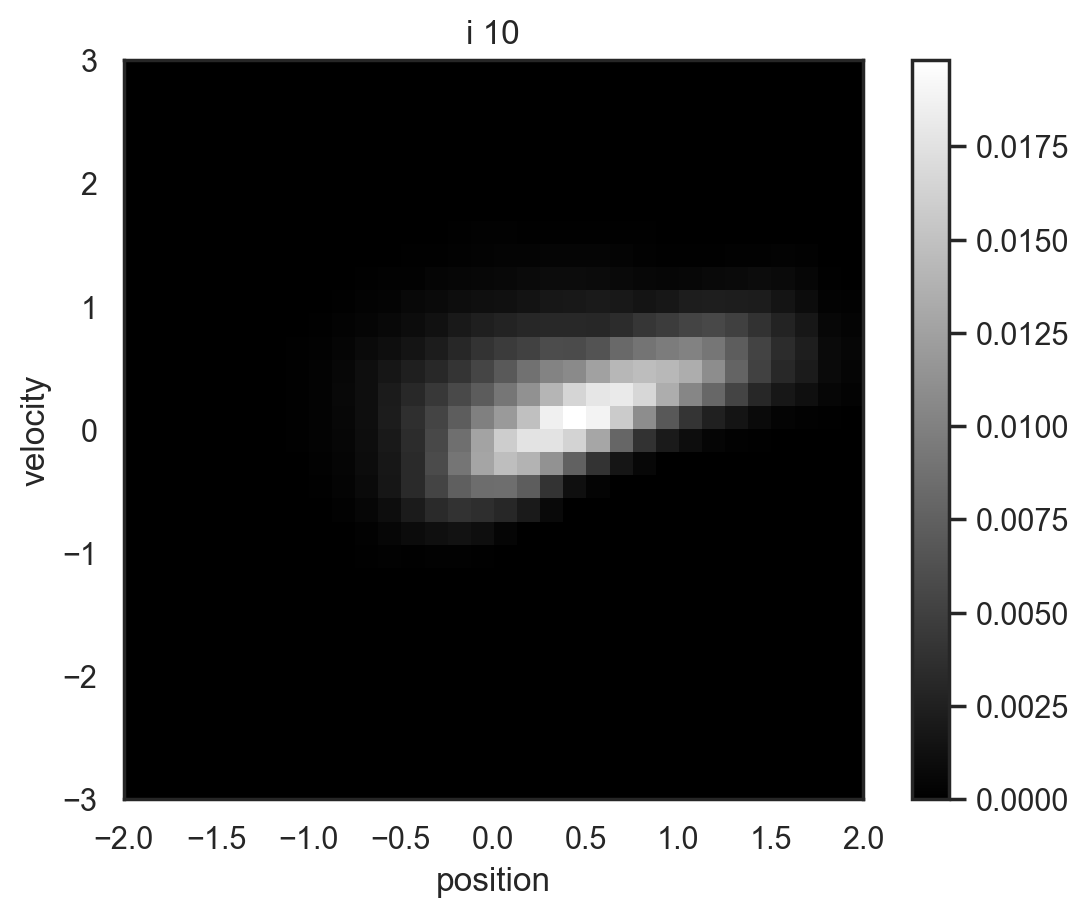

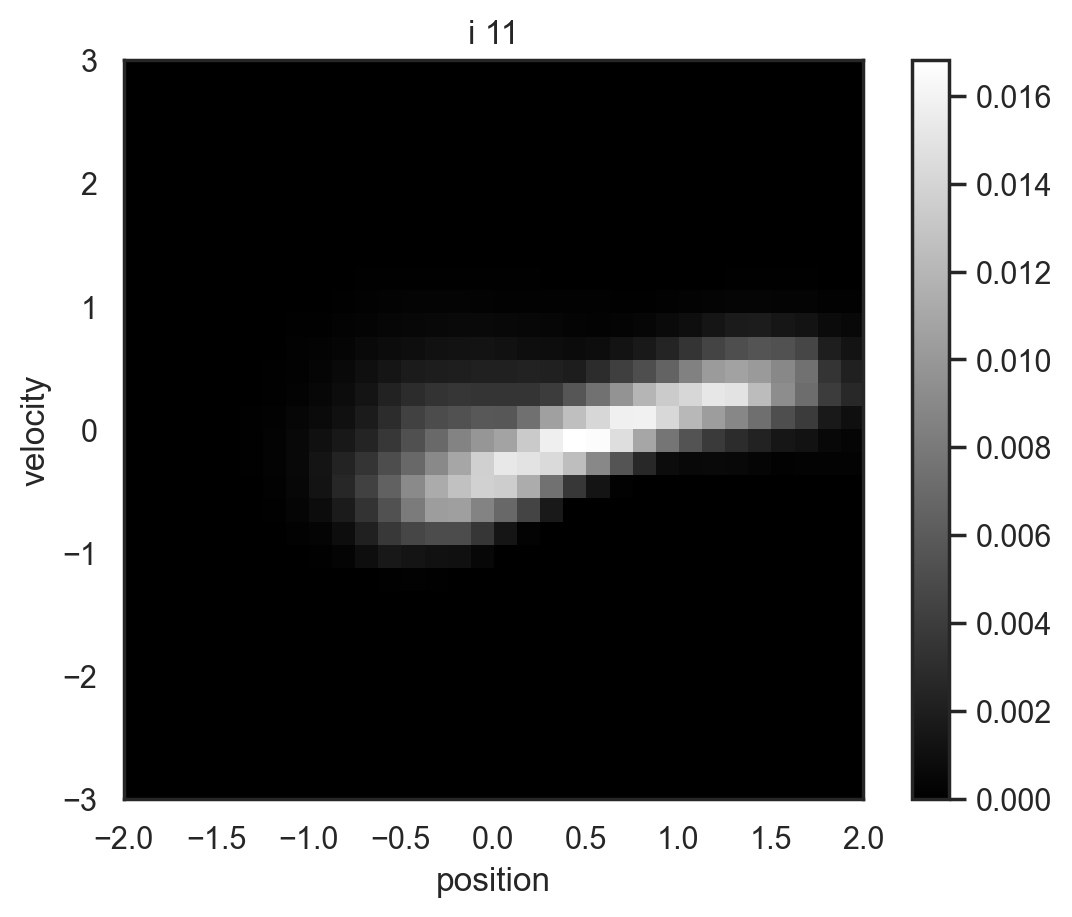

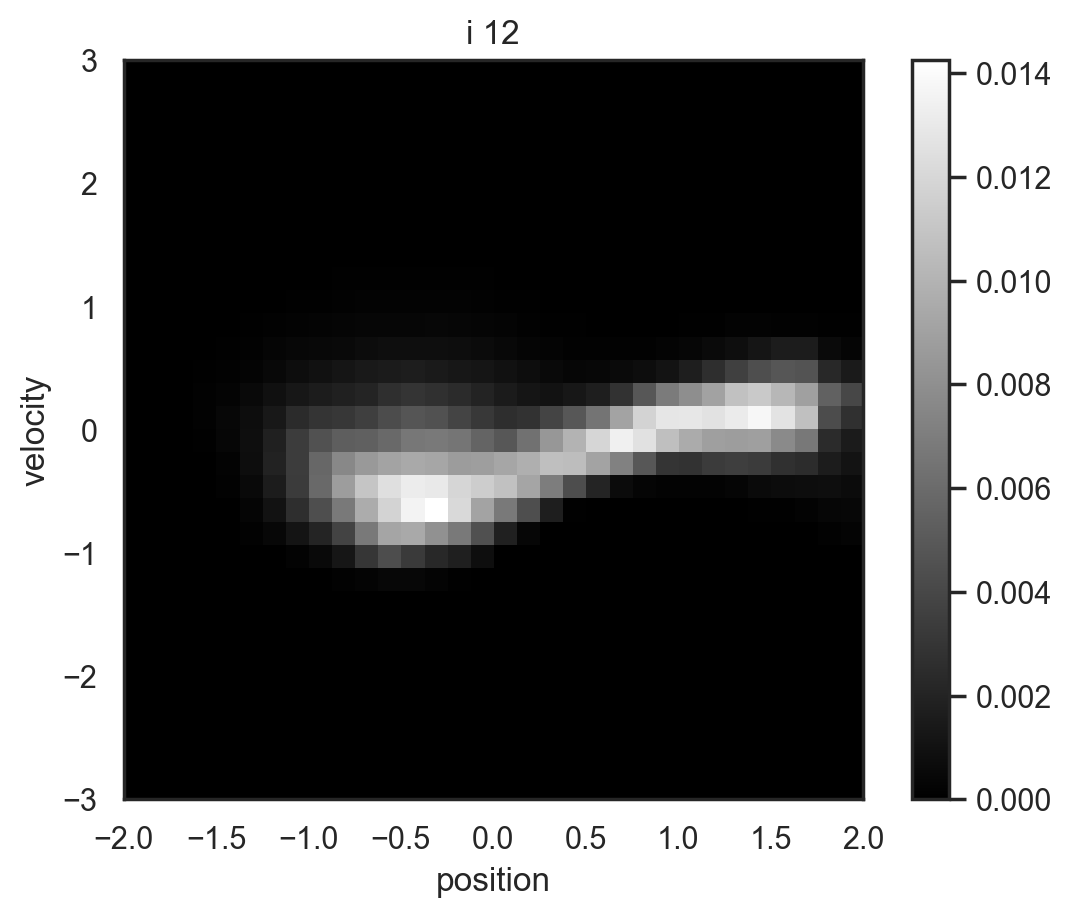

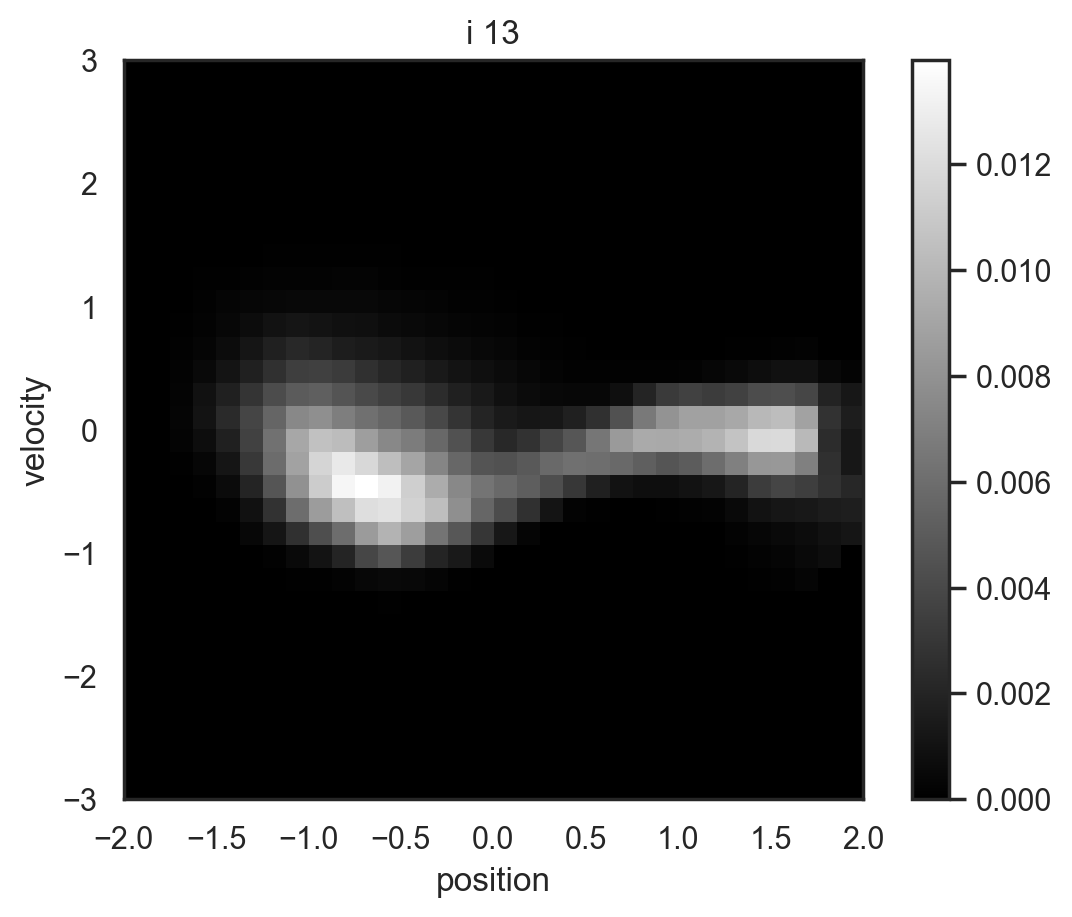

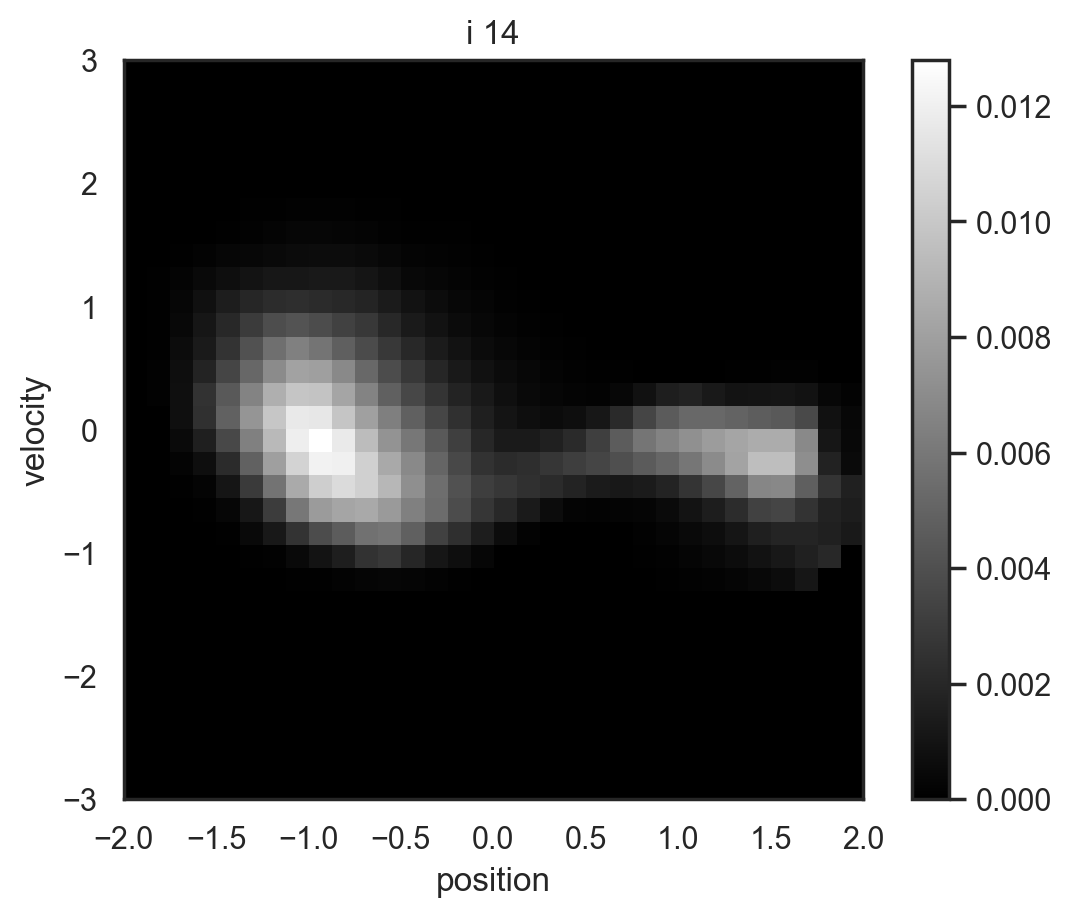

In [209]:
belief = np.zeros(n_state)
belief[starting_idx] = 1. # Encode the starting

idx_act = 2

i = 0
for t in range(n_step-1):
    
    plot_belief(belief)
    plt.title(f"i {i}")
    
    belief = np.dot(belief, p_backward[idx_act])
    belief /= belief.sum()
    i += 1

## Simulation

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

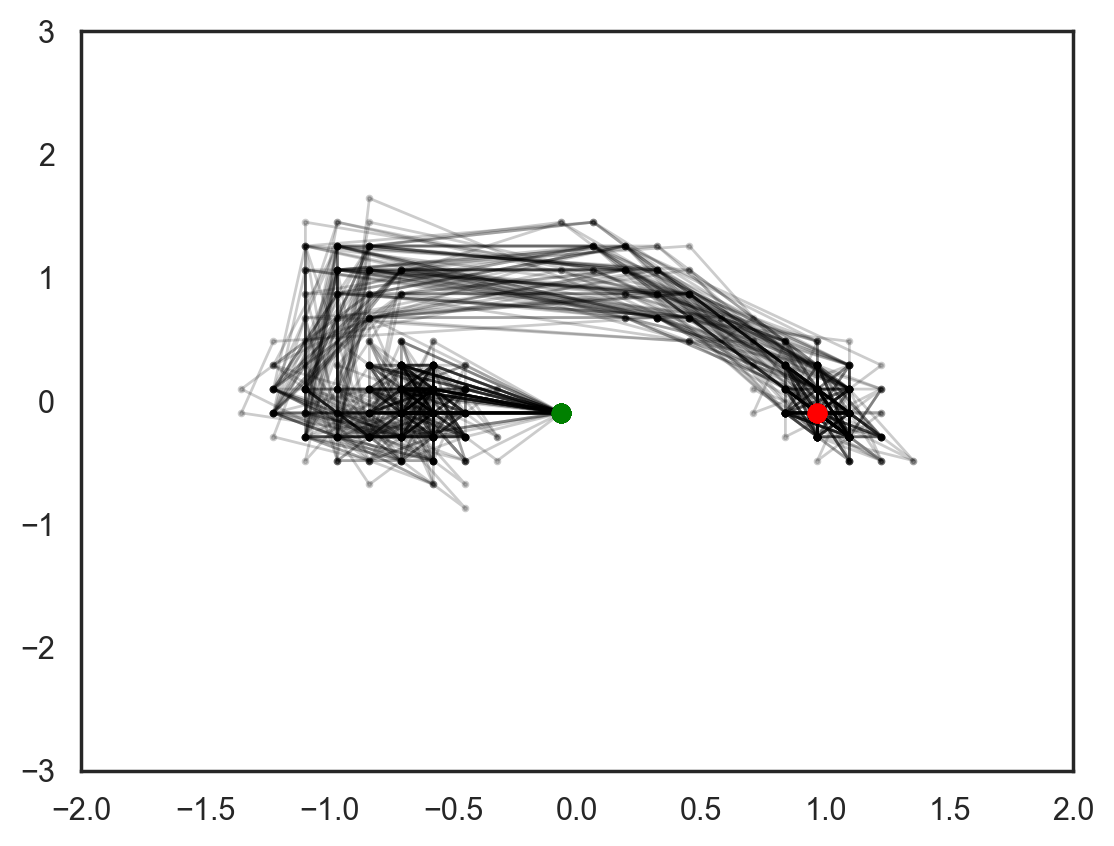

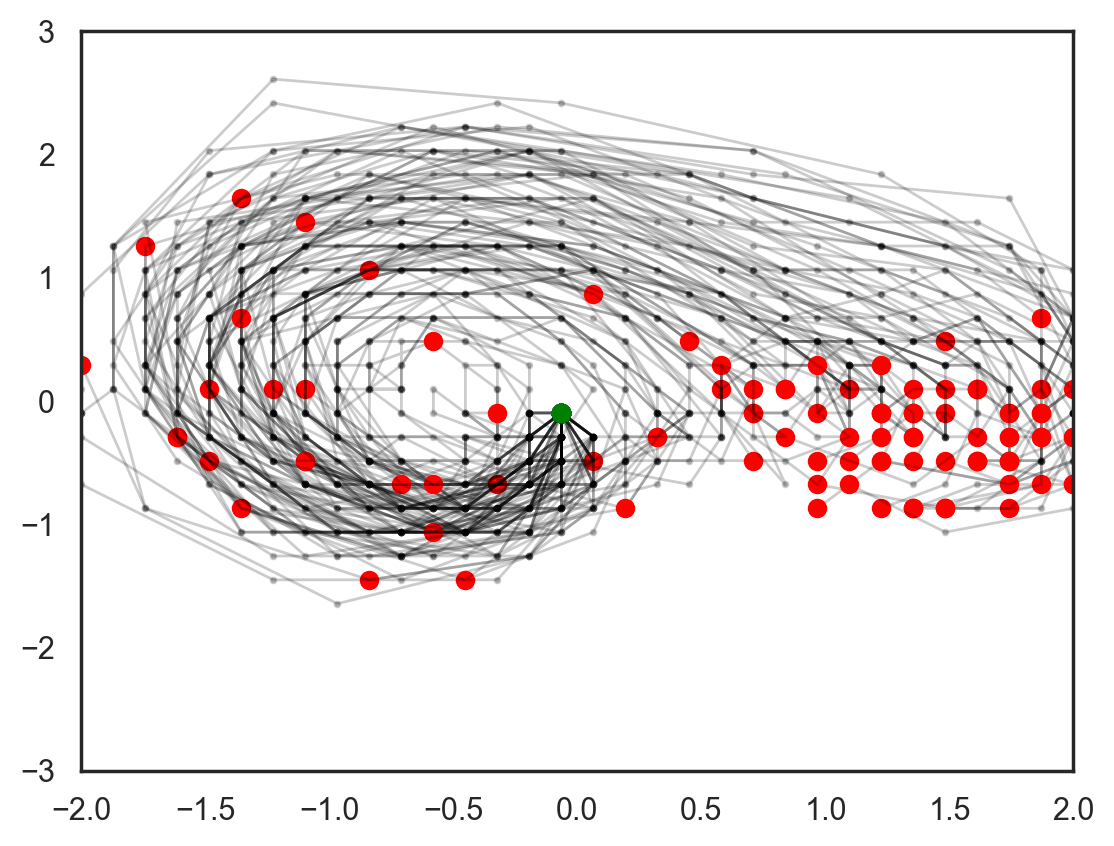

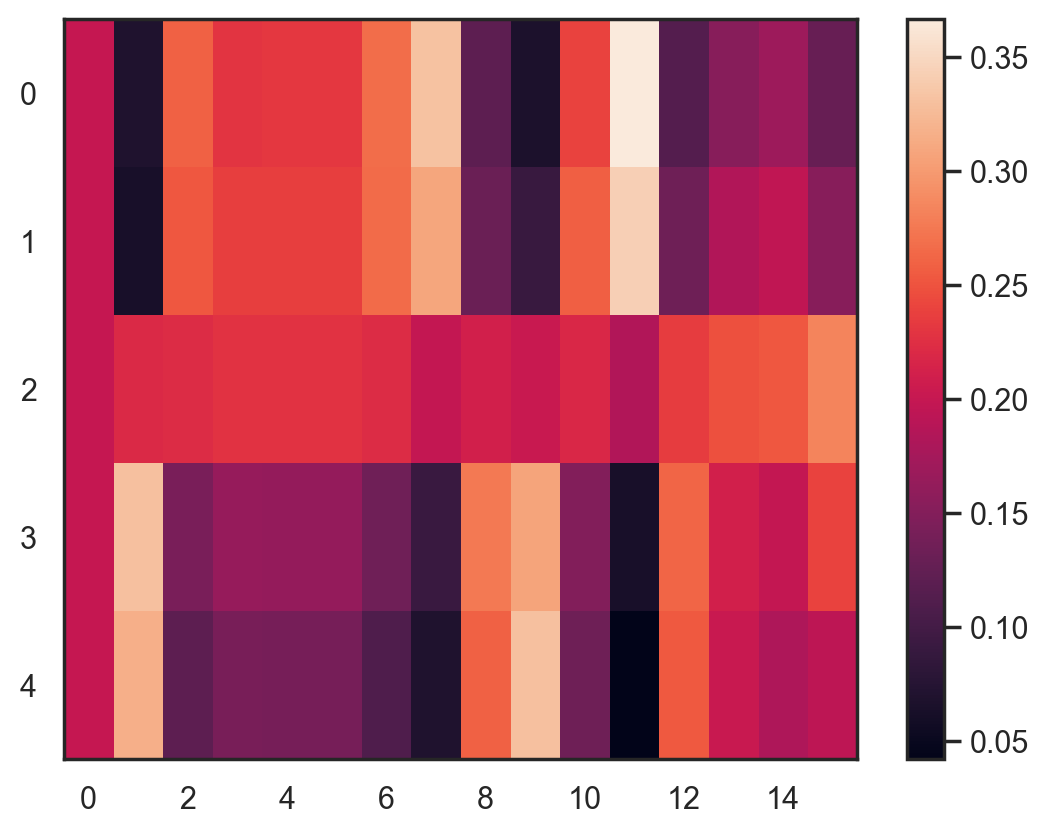

In [313]:
def normalize(q):
    q_sum = q.sum()
    if q_sum > 0:
        q /= q_sum
    return q

def safe_log(q):
    return np.log(np.maximum(q, 1e-16))

n_step = 16
n_epoch = 10

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)

tree = scipy.spatial.KDTree(coords)

goal = np.array([1.0, 0.0]) # goal = np.array([1.0, -1.0]) # goal = np.array([1.0, 0.0])
_, goal_idx = tree.query(goal)

starting = np.array([0.0, 0.0])
_, starting_idx = tree.query(starting)

d = np.ones(n_action) / n_action
    
alpha = np.ones((n_step, n_state)) # / n_state  # State dist sufficient statistics
beta = np.ones((n_step, n_action)) # / n_action # Action dist sufficient statistics

for step in range(n_step):
    alpha[step] /= alpha[step].sum()
    beta[step] /= beta[step].sum()

alpha[-1, :] = 0.
alpha[-1, goal_idx] = 1.    # Encode the goal
            
alpha[0, :] = 0.
alpha[0, starting_idx] = 1. # Encode the knowledge of current state
    
T = n_step - 1

hist_beta = np.zeros((n_epoch, n_step, n_action))
hist_alpha = np.zeros((n_epoch, n_step, n_state))
        
for epoch in tqdm(range(n_epoch), leave=False, desc="Epoch"):
    
    new_alpha = np.ones((n_step, n_state))
    new_beta = np.ones((n_step, n_action))
    
    for t in reversed(range(1, T+1)):
        
        if t < T:
            backward_msg = np.dot(beta[t+1], np.dot(p_backward, alpha[t+1]))
            forward_msg = np.dot(beta[t], np.dot(alpha[t], p_backward))
            new_alpha[t] = normalize(np.exp(safe_log(backward_msg) + safe_log(forward_msg)))
            
        q_action = np.zeros(n_action)
        for i in range(n_action):
            q_action[i] = np.dot(alpha[t-1].T, np.dot(p_backward[i], alpha[t]))
        new_beta[t] = normalize(q_action)
    
    for t in range(1, T+1):
        if t < T:
            alpha[t] += np.clip(new_alpha[t] - alpha[t], -0.1, 0.1)
        alpha[t] = normalize(alpha[t])
    
        beta[t] += np.clip(new_beta[t] - beta[t], -0.1, 0.1)
        beta[t] = normalize(beta[t])
    
    hist_beta[epoch] = beta
    hist_alpha[epoch] = alpha
    
    
# -------------------------------------------------- #
# -------------------------------------------------- #
    
n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    for t in range(0, n_step):
        state_idx = np.random.choice(np.arange(n_state), p=alpha[t])
        sample_trajectories[i, t] = coords[state_idx]
    
    
# ------------------------------------------------- #

fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

# ----------------------------------------------- #
# ----------------------------------------------- #

n_sample = 100
n_step = 16

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    
    for t in range(0, n_step):
        if t == 0:
            state_idx = starting_idx
        else:
            action_idx = np.random.choice(np.arange(n_action), p=beta[t])
            state_idx = np.random.choice(np.arange(n_state), p=p_forward[action_idx, state_idx, :]) 
        
        sample_trajectories[i, t] = coords[state_idx]
        
fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

# ------------------- #

fig, ax = plt.subplots()
im = ax.imshow(beta.T, aspect="auto", interpolation='none')
fig.colorbar(im);

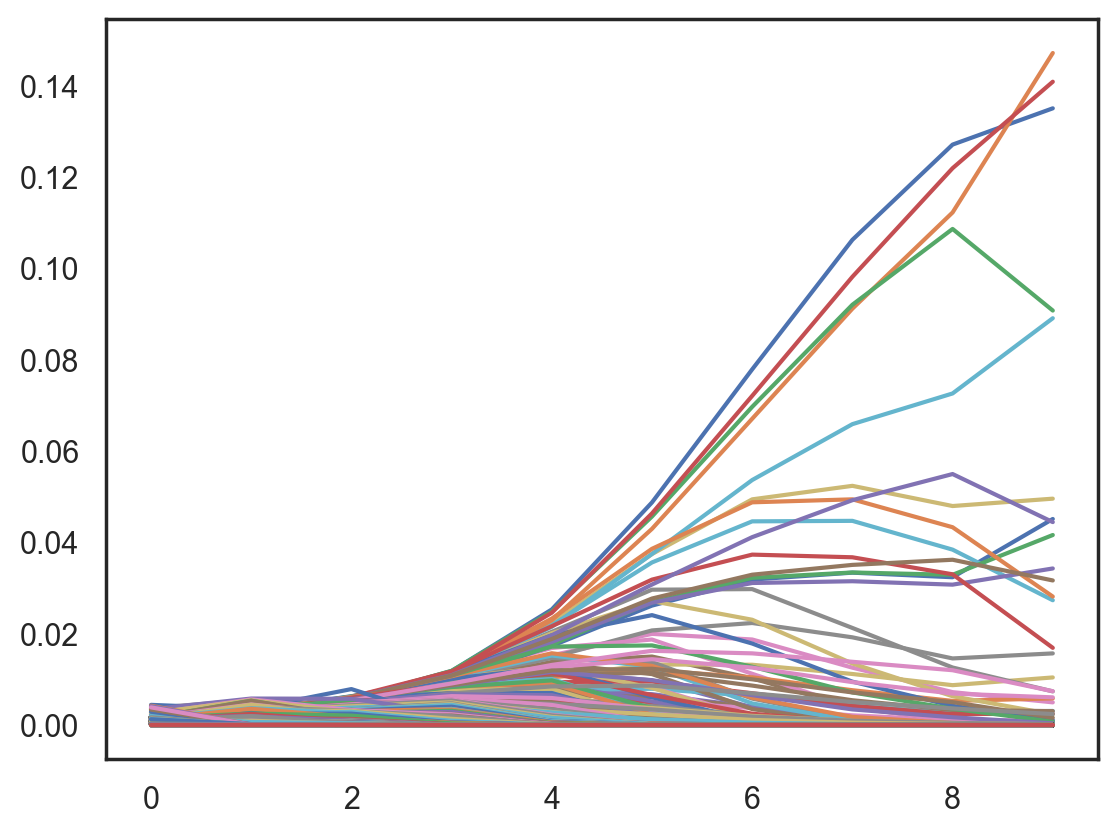

In [314]:
for state in range(n_state):
    plt.plot(hist_alpha[:, 5, state])

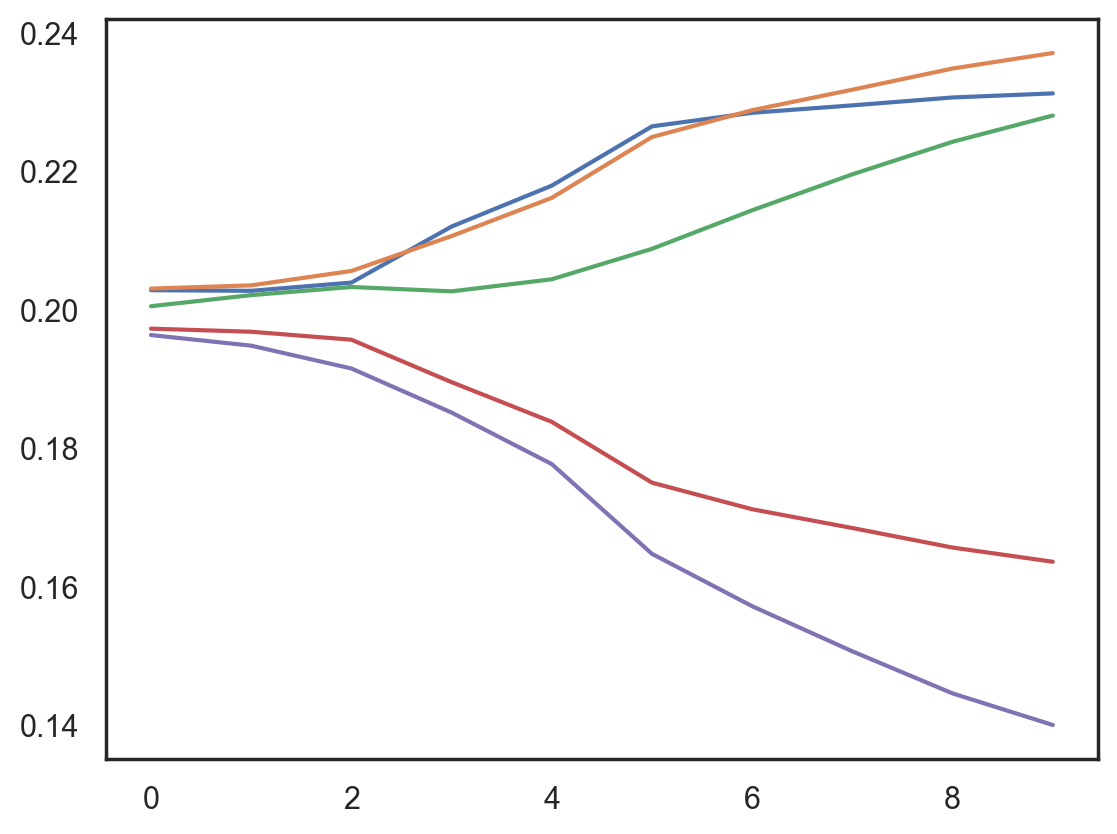

In [315]:
for action in range(n_action):
    plt.plot(hist_beta[:, 5, action])